# Python Notebook

In [5]:
## Function to prepare datatables (cleaning and hyperlinking, adding tool tips, etc) input for the database qmds
import sys, os
import pandas as pd
# Change working directory to ConnectomeDB
project_root = "/Users/sakuramaezono/Library/CloudStorage/OneDrive-YokohamaCityUniversity/Personal/05_Python_repositories/ConnectomeDB"
os.chdir(project_root)
sys.path.append(os.path.abspath("src"))

In [9]:
# Subset categorical columns
rec_cat = gene_pair_annot_receptor.iloc[:, [6]]
cat_cols = rec_cat.select_dtypes(include='object').columns

figs_rec = []

for col in cat_cols:
    # Clean values: remove HTML tags
    cleaned_values = rec_cat[col].astype(str).apply(lambda x: re.sub(r'<.*?>', '', x))

    counts = cleaned_values.value_counts().reset_index()
    counts.columns = [col, 'count']
    cat_count = str(cleaned_values.nunique())
    #fig_rec = px.pie(
    #    counts,
    #    names=col,
    #    values='count',
    #    hole=0.4,
    #    title=f"Distribution of {cat_count} {col}"
    #)
    top_n = 25
    top_counts = counts.sort_values('count', ascending=False).head(top_n)
    
    fig_rec = px.bar(
        top_counts.sort_values('count', ascending=True),
        x='count',
        y=col,
        orientation='h',
        title=f"Top {top_n} of {cat_count} "
          f"{col.rstrip() if col.rstrip().endswith('s') else col.rstrip() + 's'}"
    )

    #fig_rec.update_traces(textinfo='percent+label', textposition='inside')
    fig_rec.update_layout(
    yaxis=dict(
        tickangle=0,
        tickfont=dict(size=10)  # control size and font
    ),
    #legend_title_text=col,
    #legend=dict(
    #    orientation="v",
    #    y=0.5,
    #    yanchor="middle",
    #    x=1.05,
    #    xanchor="left"
    #),
    legend_title_text=col,
    yaxis_title=col,
    xaxis_title="Count",
    margin=dict(l=100, r=20, t=60, b=20),
    width=1200,
    height=600
)
    figs_rec.append(fig_rec)


In [21]:
# this is for HGNC gene groups
gene_pair_annot2 =gene_pair[["Interaction ID", "Human LR Pair", 
                              'Ligand HGNC ID', 'Receptor HGNC ID', 
                              "Ligand symbol and aliases",  
                              "Receptor symbol and aliases"]]

gene_pair_annot2["Human LR Pair"] = [
    f'<a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/cards/{lrPairOrig}.html">{lrPair}</a>'
    for lrPairOrig, lrPair in zip(gene_pair_disease["Human LR Pair"], gene_pair_disease["Human LR Pair"])
]

gene_pair_annot2["Interaction ID"] = gene_pair_annot2[gene_pair_annot2["Interaction ID"]].apply(
    lambda x: f"<a href='https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/database/filter/{x}.html'>{x}</a>"
)


gene_group_lim = gene_group[['hgnc_id','root_group_name']]
# Ligand groups
gene_pair_annot2["ligand_hgnc_id"] = gene_pair_annot2["Ligand HGNC ID"].astype(str).apply(lambda x: re.sub(r'<.*?>(HGNC:\d+)<.*?>', r'\1', x))
gene_pair_annot_ligand = gene_pair_annot2.merge(gene_group_lim, how='left', left_on='ligand_hgnc_id', right_on='hgnc_id')
gene_pair_annot_ligand = gene_pair_annot_ligand.rename(columns={
                                     "root_group_name": "Ligand group"}
                            )
gene_pair_annot_ligand = gene_pair_annot_ligand.drop(columns=["hgnc_id", "ligand_hgnc_id"])
# Receptor groups
gene_pair_annot2["receptor_hgnc_id"] = gene_pair_annot2["Receptor HGNC ID"].astype(str).apply(lambda x: re.sub(r'<.*?>(HGNC:\d+)<.*?>', r'\1', x))
gene_pair_annot_receptor = gene_pair_annot2.merge(gene_group_lim, how='left', left_on='receptor_hgnc_id', right_on='hgnc_id')
gene_pair_annot_receptor = gene_pair_annot_ligand.rename(columns={
                                     "root_group_name": "Receptor group"}
                            )
gene_pair_annot_receptor = gene_pair_annot_ligand.drop(columns=["hgnc_id", "receptor_hgnc_id"])

KeyError: "None of [Index(['Interaction ID', 'Human LR Pair', 'Ligand HGNC ID', 'Receptor HGNC ID',\n       'Ligand symbol and aliases', 'Receptor symbol and aliases'],\n      dtype='object')] are in the [columns]"

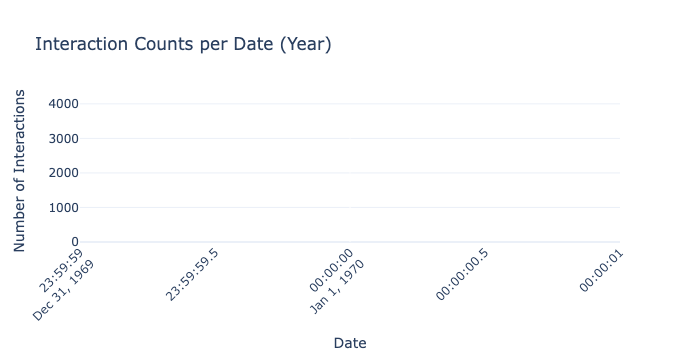

In [89]:
date_col = "Year"  # Replace with actual date column name

# Convert to datetime
gene_pair_trip[date_col] = pd.to_datetime(gene_pair_trip[date_col], errors='coerce')

# Drop NA values
date_counts = gene_pair_trip[date_col].dropna()

# Count occurrences per date
counts_per_date = date_counts.value_counts().sort_index().reset_index()
counts_per_date.columns = ['Date', 'Count']

# Create bar plot
fig_date = px.bar(
    counts_per_date,
    x="Date",
    y="Count",
    title=f"Interaction Counts per Date ({date_col})",
    labels={"Date": "Date", "Count": "Number of Interactions"},
    template="plotly_white"
)
fig_date.update_layout(xaxis_tickangle=-45)
fig_date

In [90]:
counts_per_date

,Date,Count
0,1970-01-01 00:00:00.000001969,1
1,1970-01-01 00:00:00.000001981,2
2,1970-01-01 00:00:00.000001982,2
3,1970-01-01 00:00:00.000001983,1
4,1970-01-01 00:00:00.000001985,5
5,1970-01-01 00:00:00.000001986,3
6,1970-01-01 00:00:00.000001987,3
7,1970-01-01 00:00:00.000001988,9
8,1970-01-01 00:00:00.000001989,11
9,1970-01-01 00:00:00.000001990,27


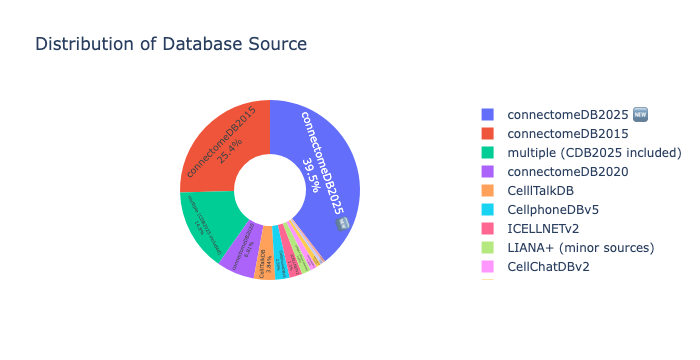

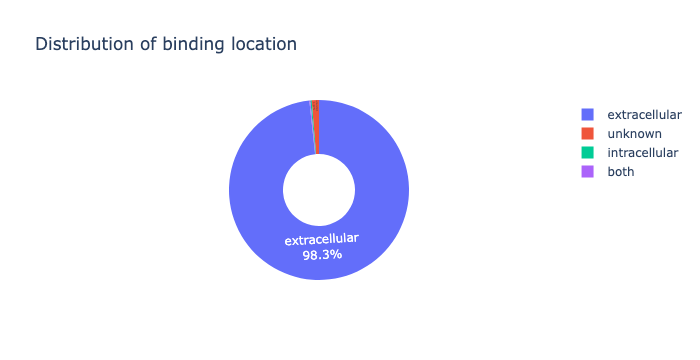

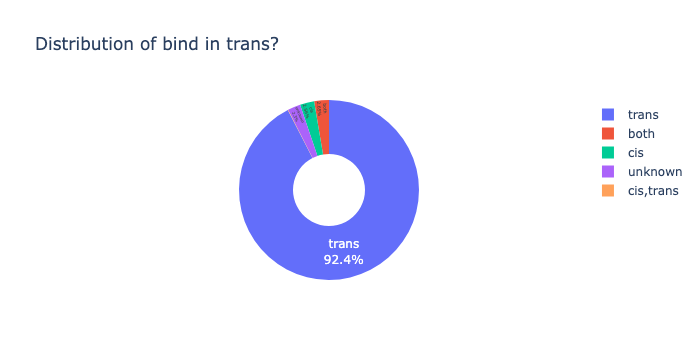

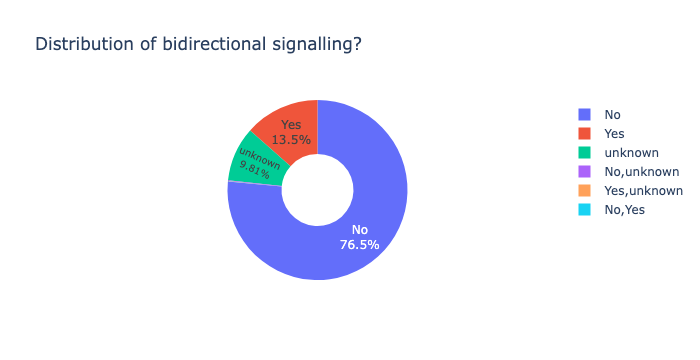

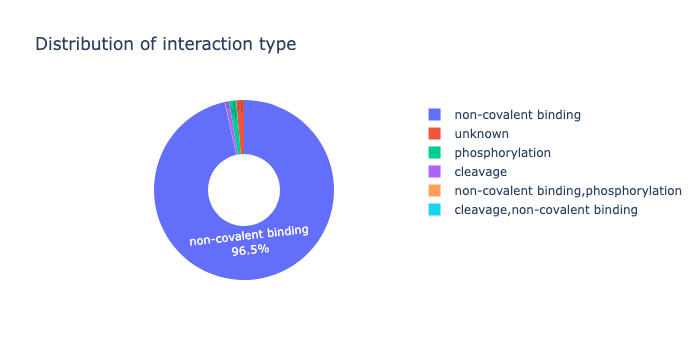

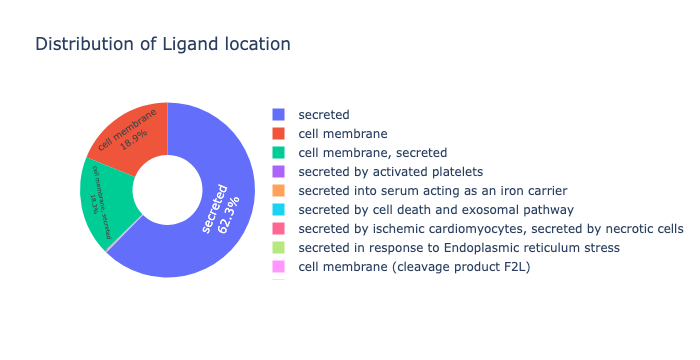

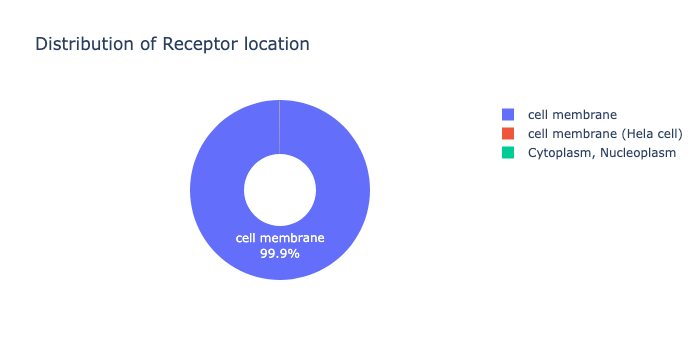

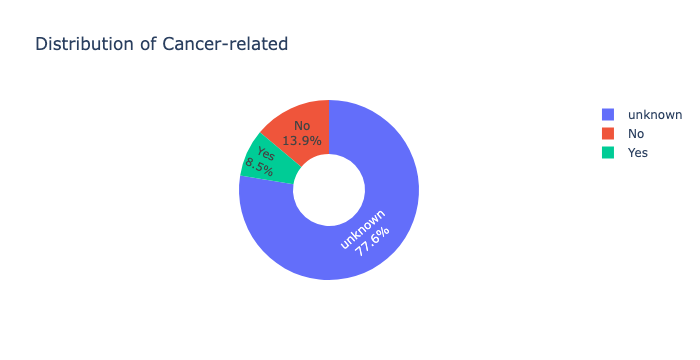

In [63]:
for col in cat_cols:
    # Remove HTML tags from each value
    cleaned_values = gene_pair[col].astype(str).apply(lambda x: re.sub(r'<.*?>', '', x))

    counts = cleaned_values.value_counts().reset_index()
    counts.columns = [col, 'count']

    fig = px.pie(
        counts,
        names=col,
        values='count',
        hole=0.4,
        title=f"Distribution of {col}"
    )
    fig.update_traces(textinfo='percent+label', textposition='inside')
    fig.show()

In [62]:
gene_pair.iloc[1, 14]

'<span title="based on hpa, perplexity, uniprot">cell membrane</span>'

In [37]:
def dedup_locations(loc_str):
    seen = set()
    result = []
    for loc in loc_str.split(','):
        loc = loc.strip()
        if loc not in seen:
            seen.add(loc)
            result.append(loc)
    return result  # return list for easy iteration later

def generate_LocToolTip(row, geneloc):
    ligand = row["Ligand"]
    original_locations = [loc.strip() for loc in row["location"].split(',')]
    original_sources = [src.strip() for src in row["source"].split(',')]

    # Get deduplicated locations
    unique_locations = dedup_locations(row["location"])

    if len(unique_locations) == 1:
        # Single tooltip case
        location = unique_locations[0]
        matching_rows = geneloc[(geneloc["Ligand"] == ligand) & (geneloc["location"].str.contains(location))]
        all_sources = matching_rows["source"].unique()
        sources_str = ", ".join(sorted(set(all_sources)))
        return f'<span title="based on {sources_str}">{location}</span>'
    else:
        # Multiple tooltips — find each (ligand, location) match in original df
        spans = []
        for loc in unique_locations:
            matching_rows = geneloc[
                (geneloc["Ligand"] == ligand) &
                (geneloc["location"].str.contains(loc))
            ]
            all_sources = matching_rows["source"].unique()
            sources_str = ", ".join(sorted(set(all_sources)))
            spans.append(f'<span title="based on {sources_str}">{loc}</span>')
        return ", ".join(spans)



In [38]:
# Group the original loc_info by Ligand
grouped = ligand_loc.groupby("Ligand").agg({
    "location": lambda x: ', '.join(x),
    "source": lambda x: ', '.join(x)
}).reset_index()

# Generate tooltips
grouped["Ligand location"] = grouped.apply(lambda row: generate_LocToolTip(row, ligand_loc), axis=1)

In [39]:
mapping_loc = dict(zip(grouped['Ligand'], grouped['Ligand location'])) 
gene_pair['Ligand location'] = gene_pair['Ligand'].replace(mapping_loc)


,LR pair,Ligand,Ligand.HGNC,Receptor,Receptor.HGNC,perplexity link,PMID,binding location,bind in trans?,bidirectional signalling?,interaction type,original source,Ligand location
0,APOA1 ABCA1,APOA1,HGNC:600,ABCA1,HGNC:29,APOA1 ABCA1,12084722,extracellular,trans,Yes,non-covalent binding,LIANA+ (minor sources),"<span title=""based on hpa, perplexity, uniprot..."
1,APOA1 ABCA1,APOA1,HGNC:600,ABCA1,HGNC:29,APOA1 ABCA1,12869555,extracellular,trans,Yes,non-covalent binding,LIANA+ (minor sources),"<span title=""based on hpa, perplexity, uniprot..."
2,APOA1 ABCA1,APOA1,HGNC:600,ABCA1,HGNC:29,APOA1 ABCA1,22271762,extracellular,trans,Yes,non-covalent binding,LIANA+ (minor sources),"<span title=""based on hpa, perplexity, uniprot..."
3,APOA1 ABCA1,APOA1,HGNC:600,ABCA1,HGNC:29,APOA1 ABCA1,30458687,extracellular,trans,Yes,non-covalent binding,LIANA+ (minor sources),"<span title=""based on hpa, perplexity, uniprot..."
4,APOE ABCA1,APOE,HGNC:613,ABCA1,HGNC:29,APOE ABCA1,14754908,extracellular,trans,No,non-covalent binding,CelllTalkDB,"<span title=""based on hpa, perplexity, uniprot..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,XCL1 XCR1,XCL1,HGNC:10645,XCR1,HGNC:1625,XCL1 XCR1,9632725,extracellular,trans,No,non-covalent binding,connectomeDB2015,"<span title=""based on perplexity, uniprot"">sec..."
5134,XCL1 XCR1,XCL1,HGNC:10645,XCR1,HGNC:1625,XCL1 XCR1,11446740,extracellular,trans,No,non-covalent binding,connectomeDB2015,"<span title=""based on perplexity, uniprot"">sec..."
5135,XCL2 XCR1,XCL2,HGNC:10646,XCR1,HGNC:1625,XCL2 XCR1,9632725,extracellular,trans,No,non-covalent binding,connectomeDB2015,"<span title=""based on perplexity, uniprot"">sec..."
5136,RSPO1 ZNRF3,RSPO1,HGNC:21679,ZNRF3,HGNC:18126,RSPO1 ZNRF3,24349440,extracellular,trans,No,non-covalent binding,connectomeDB2015,"<span title=""based on hpa, perplexity, uniprot..."


In [40]:
mapping_loc

{'A2M': '<span title="based on perplexity, uniprot">secreted</span>',
 'ACE': '<span title="based on hpa, uniprot">secreted</span>, <span title="based on perplexity, uniprot">cell membrane</span>',
 'ADA': '<span title="based on hpa, uniprot">cell membrane</span>',
 'ADAM10': '<span title="based on hpa, perplexity, uniprot">cell membrane</span>',
 'ADAM11': '<span title="based on perplexity, uniprot">cell membrane</span>',
 'ADAM12': '<span title="based on hpa, perplexity, uniprot">secreted</span>, <span title="based on hpa, perplexity, uniprot">cell membrane</span>',
 'ADAM15': '<span title="based on perplexity">cell membrane</span>',
 'ADAM17': '<span title="based on perplexity, uniprot">cell membrane</span>',
 'ADAM2': '<span title="based on perplexity">cell membrane</span>',
 'ADAM23': '<span title="based on perplexity, uniprot">secreted</span>, <span title="based on perplexity, uniprot">cell membrane</span>',
 'ADAM28': '<span title="based on hpa, perplexity, uniprot">secreted</sp

In [9]:
top_pathway_df=fetchGSheet.kegg_pathway_info[["LR Pair", "kegg_pathway_id", "kegg_relationship", "kegg_pathway_name"]]
top_pathway_df["kegg_pathway_id"] = [
    f'<a href="https://www.kegg.jp/pathway/{id}" target="_blank">{id}</a>'
    for id in top_pathway_df["kegg_pathway_id"]]
top_pathway_df["kegg_pathway_id"] = top_pathway_df["kegg_pathway_id"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x)
top_pathway_df = top_pathway_df.rename(columns={
                                      "kegg_pathway_name": "KEGG Pathway",
                                      "kegg_relationship": "KEGG relationship",
                                      "kegg_pathway_id": "KEGG Pathway ID"
    
})
gene_pair = gene_pair.merge(top_pathway_df, how='left', left_on='Human LR Pair', right_on='LR Pair')

/var/folders/r4/pjgb1k_x7fv9xgcb_dg70bnm0000gn/T/ipykernel_85568/1629520948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pathway_df["kegg_pathway_id"] = [


In [10]:
gene_pair

,Human LR Pair,Ligand,Ligand HGNC ID,Receptor,Receptor HGNC ID,Perplexity,PMID,binding location,bind in trans?,bidirectional signalling?,...,Receptor location,Ligand name,Ligand MGI ID,Ligand RGD ID,Ligand Aliases,Ligand Old symbol,LR Pair,KEGG Pathway ID,KEGG relationship,KEGG Pathway
0,CADM1 CADM1,CADM1,HGNC:5951,CADM1,HGNC:5951,CADM1 CADM1,17250899,extracellular,trans,Yes,...,Membrane,cell adhesion molecule 1,MGI:1889272,RGD:1310999,"NECL2, ST17, BL2, SYNCAM, IGSF4A, Necl-2, SYNC...","TSLC1, IGSF4",CADM1 CADM1,"<a href=""https://www.kegg.jp/pathway/hsa04514""...",binding/association,Cell adhesion molecules
1,CADM1 CADM1,CADM1,HGNC:5951,CADM1,HGNC:5951,CADM1 CADM1,25268382,extracellular,trans,Yes,...,Membrane,cell adhesion molecule 1,MGI:1889272,RGD:1310999,"NECL2, ST17, BL2, SYNCAM, IGSF4A, Necl-2, SYNC...","TSLC1, IGSF4",CADM1 CADM1,"<a href=""https://www.kegg.jp/pathway/hsa04514""...",binding/association,Cell adhesion molecules
2,CADM1 CADM3,CADM1,HGNC:5951,CADM3,HGNC:17601,CADM1 CADM3,15741237,extracellular,trans,No,...,Membrane,cell adhesion molecule 1,MGI:1889272,RGD:1310999,"NECL2, ST17, BL2, SYNCAM, IGSF4A, Necl-2, SYNC...","TSLC1, IGSF4",NaN,NaN,NaN,NaN
3,CADM3 CADM1,CADM3,HGNC:17601,CADM1,HGNC:5951,CADM3 CADM1,15741237,extracellular,trans,unknown,...,Membrane,cell adhesion molecule 3,MGI:2137858,RGD:1307035,"BIgR, FLJ10698, TSLL1, NECL1, SynCAM3, Necl-1",IGSF4B,NaN,NaN,NaN,NaN
4,CADM3 CADM3,CADM3,HGNC:17601,CADM3,HGNC:17601,CADM3 CADM3,15741237,extracellular,trans,No,...,Membrane,cell adhesion molecule 3,MGI:2137858,RGD:1307035,"BIgR, FLJ10698, TSLL1, NECL1, SynCAM3, Necl-1",IGSF4B,CADM3 CADM3,"<a href=""https://www.kegg.jp/pathway/hsa04514""...",binding/association,Cell adhesion molecules
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,XCL2 XCR1,XCL2,HGNC:10646,XCR1,HGNC:1625,XCL2 XCR1,9632725,extracellular,trans,No,...,Membrane,X-C motif chemokine ligand 2,MGI:104593,NaN,SCM-1b,SCYC2,XCL2 XCR1,"<a href=""https://www.kegg.jp/pathway/hsa04062""...",activation;binding/association,Chemokine signaling pathway
10726,ZG16B CXCR4,ZG16B,HGNC:30456,CXCR4,HGNC:2561,ZG16B CXCR4,20802527,extracellular,trans,No,...,Membrane,zymogen granule protein 16B,MGI:106021,RGD:1562673,"HRPE773, PRO1567, JCLN2",N/A,NaN,NaN,NaN,NaN
10727,ZG16B TLR2,ZG16B,HGNC:30456,TLR2,HGNC:11848,ZG16B TLR2,20802527,extracellular,trans,No,...,Membrane,zymogen granule protein 16B,MGI:106021,RGD:1562673,"HRPE773, PRO1567, JCLN2",N/A,NaN,NaN,NaN,NaN
10728,ZG16B TLR4,ZG16B,HGNC:30456,TLR4,HGNC:11850,ZG16B TLR4,20802527,extracellular,trans,No,...,Membrane,zymogen granule protein 16B,MGI:106021,RGD:1562673,"HRPE773, PRO1567, JCLN2",N/A,NaN,NaN,NaN,NaN


In [61]:
## Function to prepare functional annotation datatable
import sys, os
from itables import init_notebook_mode
import pandas as pd
from itables import show
from itables import options
from IPython.display import HTML, display
import numpy as np
from bs4 import BeautifulSoup
from createDataTable import gene_pair, gene_pair0, generate_perplexity_link_pmid
import warnings
import fetchGSheet 
import string

def make_ids_unique(series):
    return [
        f"{id_val}{letter}"
        #if count > 1 else id_val -- UNCOMMENT SO UNIQUE ONES ARE ALSO WITH APPENDED LETTER ["A"]
        for id_val, count, letter in zip(
            series,
            series.groupby(series).transform('count'),
            series.groupby(series).cumcount().map(lambda i: string.ascii_uppercase[i] if i < 26 else f"_{i}")
        )
    ]

gene_pair0 = gene_pair0.dropna(subset=['Human LR Pair'])
mapping_ID = dict(zip(gene_pair0['Human LR Pair'], gene_pair0['Interaction ID']))
gene_pair_PMID = fetchGSheet.gene_pair.dropna(axis=1, how='all')
gene_pair_PMID = gene_pair_PMID[gene_pair_PMID['LR pair'] != '']
gene_pair_PMID= gene_pair_PMID[["LR pair", "PMID", "original source"]]
# Mapping for replacements
mapping = dict(zip(fetchGSheet.src_info['original source'], fetchGSheet.src_info['shortname']))
# Replace values in the column based on the mapping
gene_pair_PMID['Database Source'] = gene_pair_PMID['original source'].replace(mapping)

# Replace values in the column based on the mapping
gene_pair_PMID["Interaction ID"] = gene_pair_PMID['LR pair'].replace(mapping_ID)
df_pub = pd.read_csv("data/pubmed_results.csv", usecols=[0,1,3,4,5])
gene_pair_PMID["PMID"] = gene_pair_PMID["PMID"].astype(str)
df_pub["PMID"] = df_pub["PMID"].astype(str)
gene_pair_trip = pd.merge(gene_pair_PMID, df_pub, how='left', on='PMID')
### patch for the BioRxiV ###
gene_pair_trip["Year"] = gene_pair_trip["Year"].apply(
    lambda x: "2024" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "Species Specificity", "NaN", ""] else x
)
###
gene_pair_trip["Year"] = pd.to_numeric(gene_pair_trip["Year"], errors="coerce").astype("Int64")
gene_pair_trip = gene_pair_trip.merge(gene_pair, how='left', left_on='Interaction ID', right_on=gene_pair.columns[0])
gene_pair_trip = gene_pair_trip.drop(columns=["Interaction ID", gene_pair.columns[2], gene_pair.columns[5],gene_pair.columns[6]])
gene_pair_trip = gene_pair_trip.drop_duplicates()
gene_pair_trip = gene_pair_trip.reset_index(drop=True)  

# Add perplexity query
gene_pair_trip = gene_pair_trip.rename(columns={"LR pair": "Human LR Pair"})
gene_pair_trip["Perplexity"] = gene_pair_trip.apply(generate_perplexity_link_pmid, axis=1)
gene_pair_trip = gene_pair_trip.drop(columns=["Human LR Pair", "original source"])

gene_pair_trip["Species"] = gene_pair_trip["Species"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "Species Specificity", "NaN", ""] else x
)

### patch for the BioRxiV ###
gene_pair_trip["Title"] = gene_pair_trip["Title"].apply(
    lambda x: "ACKR5/GPR182 is a scavenger receptor for the atypical chemokine CXCL17, GPR15L and various endogenous peptides." if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "NaN", ""] else x
)

### Pop-up for title
gene_pair_trip["Title"] = [
    f'<span title="{title}">{title}</span>'
    for title in gene_pair_trip["Title"]
]

gene_pair_trip["Journal"] = gene_pair_trip["Journal"].apply(
    lambda x: "BioRxiv (preprint)" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "NaN", ""] else x
)


gene_pair_trip["PMID"] = [
    f'<a href="https://pubmed.ncbi.nlm.nih.gov/{pmid}" target="_blank">{pmid}</a>'
    if pd.notna(pmid) and str(pmid).isdigit()
    else f'<a href="{pmid}" target="_blank">BioRxiv</a>'
    for pmid in gene_pair_trip["PMID"]
]
####

df_annot=pd.read_csv("data/journal_abbv.csv")
mapping = dict(zip(df_annot['Journal Name'], df_annot['Abbreviation']))
# Replace values in the column based on the mapping
gene_pair_trip["JournalAbbv"] = gene_pair_trip['Journal'].replace(mapping)
gene_pair_trip["Journal"] = [
    f'<span title="{Journal}">{JournalAbbv}</span>'
    for Journal, JournalAbbv in zip(gene_pair_trip["Journal"], gene_pair_trip["JournalAbbv"])
    ]
gene_pair_trip = gene_pair_trip.drop(columns=['JournalAbbv'])

# Make ID unique
gene_pair_trip = gene_pair_trip.sort_values(by='Year', ascending=True)
gene_pair_trip[gene_pair_trip.columns[6]] = make_ids_unique(gene_pair_trip[gene_pair_trip.columns[6]])
gene_pair_trip = gene_pair_trip.sort_values(by='Year', ascending=False)
first_columns=[gene_pair_trip.columns[6], gene_pair_trip.columns[7], 'Perplexity','Database Source','PMID', 'Year','Journal', 'Title',gene_pair_trip.columns[21], gene_pair_trip.columns[22]]
gene_pair_trip = gene_pair_trip[first_columns + [col for col in gene_pair_trip.columns if col not in first_columns]]
gene_pair_trip = gene_pair_trip.reset_index(drop=True)  

In [62]:
gene_pair_trip

,"<span title=""Double-click header of Interaction ID to ensure all values are shown"">Interaction ID&nbsp;</span>","<span title="" Ligand-Receptor Interacting Pair, as described in Liu et al. (PMID: XXXXXX)"">Human LR Pair</span>",Perplexity,Database Source,PMID,Year,Journal,Title,"<span title=""Double-click header of Ligand symbol and aliases to ensure all values are shown"">Ligand symbol and aliases&nbsp;</span>","<span title=""Double-click header of Receptor symbol and aliases to ensure all values are shown"">Receptor symbol and aliases&nbsp;</span>",...,"<span title=""Double-click header of Dog Receptor Ensembl ID to ensure all values are shown"">Dog Receptor Ensembl ID&nbsp;</span>","<span title=""Double-click header of Dog Receptor to ensure all values are shown"">Dog Receptor&nbsp;</span>","<span title=""Double-click header of Horse Ligand Ensembl ID to ensure all values are shown"">Horse Ligand Ensembl ID&nbsp;</span>","<span title=""Double-click header of Horse Ligand to ensure all values are shown"">Horse Ligand&nbsp;</span>","<span title=""Double-click header of Horse Receptor Ensembl ID to ensure all values are shown"">Horse Receptor Ensembl ID&nbsp;</span>","<span title=""Double-click header of Horse Receptor to ensure all values are shown"">Horse Receptor&nbsp;</span>","<span title=""Double-click header of Sheep Ligand Ensembl ID to ensure all values are shown"">Sheep Ligand Ensembl ID&nbsp;</span>","<span title=""Double-click header of Sheep Ligand to ensure all values are shown"">Sheep Ligand&nbsp;</span>","<span title=""Double-click header of Sheep Receptor Ensembl ID to ensure all values are shown"">Sheep Receptor Ensembl ID&nbsp;</span>","<span title=""Double-click header of Sheep Receptor to ensure all values are shown"">Sheep Receptor&nbsp;</span>"
0,CDB03097A,"<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.perplexity.ai/search?q=Wh...",connectomeDB2025 🆕,"<a href=""https://pubmed.ncbi.nlm.nih.gov/40083...",2025,"<span title=""International journal of biologic...","<span title=""Thrombospondin 1 Promotes Cytoske...","THBS1, TSP1, THBS, TSP, THBS-1, TSP-1","ITGA1, VLA1, CD49a",...,ENSCAFG00845000521,ITGA1,ENSECAG00000008923,THBS1,ENSECAG00000017386,ITGA1,ENSOARG00020008733,THBS1,ENSOARG00020003919,ITGA1
1,CDB02983A,"<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.perplexity.ai/search?q=Wh...",Peiwen ligand query,"<a href=""https://pubmed.ncbi.nlm.nih.gov/39721...",2025,"<span title=""Advanced science"">Adv. Sci.</span>","<span title=""SPP1-ITGα5/β1 Accelerates Calcifi...","SPP1, BNSP, OPN, BSPI, ETA-1, lnc-PKD2-2-3","ITGA5, FNRA, CD49e",...,ENSCAFG00845016791,ITGA5,ENSECAG00000017191,SPP1,ENSECAG00000024979,ITGA5,ENSOARG00020024091,SPP1,ENSOARG00020016394,ITGA5
2,CDB03101B,"<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.perplexity.ai/search?q=Wh...",connectomeDB2025 🆕,"<a href=""https://pubmed.ncbi.nlm.nih.gov/40083...",2025,"<span title=""International journal of biologic...","<span title=""Thrombospondin 1 Promotes Cytoske...","THBS1, TSP1, THBS, TSP, THBS-1, TSP-1","ITGA6, CD49f, VLA-6, ITGA6A, ITGA6B",...,ENSCAFG00845028626,ITGA6,ENSECAG00000008923,THBS1,ENSECAG00000001652,ITGA6,ENSOARG00020008733,THBS1,ENSOARG00020002418,ITGA6
3,CDB02987D,"<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.perplexity.ai/search?q=Wh...",Peiwen ligand query,"<a href=""https://pubmed.ncbi.nlm.nih.gov/39721...",2025,"<span title=""Advanced science"">Adv. Sci.</span>","<span title=""SPP1-ITGα5/β1 Accelerates Calcifi...","SPP1, BNSP, OPN, BSPI, ETA-1, lnc-PKD2-2-3","ITGB1, FNRB, MSK12, MDF2, CD29, GPIIA",...,ENSCAFG00845002947,ITGB1,ENSECAG00000017191,SPP1,ENSECAG00000022498,ITGB1,ENSOARG00020024091,SPP1,ENSOARG00020022585,ITGB1
4,CDB03114A,"<a href=""https://comp.med.yokohama-cu.ac.jp/co...","<a href=""https://www.perplexity.ai/search?q=Wh...",connectomeDB2025 🆕,"<a href=""https://pubmed.ncbi.nlm.nih.gov/32567...",202

In [56]:
gene_pair_trip = gene_pair_trip.sort_values(by='Year', ascending=True)

In [59]:
gene_pair_trip[gene_pair_trip.columns[6]]

3559    CDB01436
4696    CDB03042
4695    CDB03042
1674    CDB02479
3362    CDB01128
          ...   
5175    CDB02370
2008    CDB02983
2014    CDB02987
2085    CDB03097
2089    CDB03101
Name: <span title="Double-click header of Interaction ID to ensure all values are shown">Interaction ID&nbsp;</span>, Length: 5176, dtype: object

In [57]:
gene_pair_trip[gene_pair_trip.columns[6]] = make_ids_unique(gene_pair_trip[gene_pair_trip.columns[6]])

TypeError: string indices must be integers, not 'float'

In [19]:
df_pub = pd.read_csv("data/pubmed_results.csv", usecols=[0,1,3,4,5])
gene_pair_PMID["PMID"] = gene_pair_PMID["PMID"].astype(str)
df_pub["PMID"] = df_pub["PMID"].astype(str)
gene_pair_trip = pd.merge(gene_pair_PMID, df_pub, how='left', on='PMID')
### patch for the BioRxiV ###
gene_pair_trip["Year"] = gene_pair_trip["Year"].apply(
    lambda x: "2024" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "Species Specificity", "NaN", ""] else x
)
###
gene_pair_trip["Year"] = pd.to_numeric(gene_pair_trip["Year"], errors="coerce").astype("Int64")
gene_pair_trip = gene_pair_trip.merge(gene_pair, how='left', left_on='Interaction ID', right_on=gene_pair.columns[0])
gene_pair_trip = gene_pair_trip.drop(columns=["Interaction ID", gene_pair.columns[2], gene_pair.columns[5],gene_pair.columns[6]])
gene_pair_trip = gene_pair_trip.drop_duplicates()
gene_pair_trip = gene_pair_trip.reset_index(drop=True)  

# Add perplexity query
gene_pair_trip = gene_pair_trip.rename(columns={"LR pair": "Human LR Pair"})
gene_pair_trip["Perplexity"] = gene_pair_trip.apply(generate_perplexity_link_pmid, axis=1)
gene_pair_trip = gene_pair_trip.drop(columns=["Human LR Pair", "original source"])

gene_pair_trip["Species"] = gene_pair_trip["Species"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "Species Specificity", "NaN", ""] else x
)

### patch for the BioRxiV ###
gene_pair_trip["Title"] = gene_pair_trip["Title"].apply(
    lambda x: "ACKR5/GPR182 is a scavenger receptor for the atypical chemokine CXCL17, GPR15L and various endogenous peptides." if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "NaN", ""] else x
)

### Pop-up for title
gene_pair_trip["Title"] = [
    f'<span title="{title}">{title}</span>'
    for title in gene_pair_trip["Title"]
]

gene_pair_trip["Journal"] = gene_pair_trip["Journal"].apply(
    lambda x: "BioRxiv (preprint)" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", "NaN", ""] else x
)


gene_pair_trip["PMID"] = [
    f'<a href="https://pubmed.ncbi.nlm.nih.gov/{pmid}" target="_blank">{pmid}</a>'
    if pd.notna(pmid) and str(pmid).isdigit()
    else f'<a href="{pmid}" target="_blank">BioRxiv</a>'
    for pmid in gene_pair_trip["PMID"]
]
####

df_annot=pd.read_csv("data/journal_abbv.csv")
mapping = dict(zip(df_annot['Journal Name'], df_annot['Abbreviation']))
# Replace values in the column based on the mapping
gene_pair_trip["JournalAbbv"] = gene_pair_trip['Journal'].replace(mapping)
gene_pair_trip["Journal"] = [
    f'<span title="{Journal}">{JournalAbbv}</span>'
    for Journal, JournalAbbv in zip(gene_pair_trip["Journal"], gene_pair_trip["JournalAbbv"])
    ]
gene_pair_trip = gene_pair_trip.drop(columns=['JournalAbbv'])

# Make ID unique
gene_pair_trip = gene_pair_trip.sort_values(by='Year', ascending=True)

In [37]:
nan_rows = gene_pair_trip[gene_pair_trip[gene_pair_trip.columns[6]].isna()]

# Print out the rows with NaN in the 6th column
print(pd.DataFrame(nan_rows))

                                        PMID Database Source  \
5024  <a href="" target="_blank">BioRxiv</a>                   

                                                  Title  \
5024  <span title="ACKR5/GPR182 is a scavenger recep...   

                                                Journal  Year  Species  \
5024  <span title="BioRxiv (preprint)">BioRxiv (prep...  2024  unknown   

     <span title="Double-click header of Interaction ID to ensure all values are shown">Interaction ID&nbsp;</span>  \
5024                                                NaN                                                               

     <span title=" Ligand-Receptor Interacting Pair, as described in Liu et al. (PMID: XXXXXX)">Human LR Pair</span>  \
5024                                                NaN                                                                

     <span title=" Official Gene Symbol; Hover on symbols below to show gene names">Ligand&nbsp;&nbsp;&nbsp;</span>  \
5024

In [29]:
input_file ="data/rna_tissue_consensus.tsv"
ligand_list = gene_pair0["Ligand"].tolist()
receptor_list = gene_pair0["Receptor"].tolist()
unique_genes = list(set(ligand_list + receptor_list))

connectomeDB = pd.read_table(input_file, sep="\t")
intersection = pd.Series(list(set(connectomeDB['Gene name']).intersection(unique_genes)))
connectomeDB = connectomeDB[connectomeDB["Gene name"].isin(intersection)]
connectomeDB = connectomeDB.rename(columns={"nTPM": "normalized TPM"})
connectomeDB

# Merge in categories
cellCat = pd.read_table("data/rna_tissue_consensus_tissues.tsv", sep="\t")
connectomeDB = connectomeDB.merge(cellCat, how='left', on='Tissue')
connectomeDB = connectomeDB.drop_duplicates()
def plot_gene_expression(df):
    # Define cell category colors
    colors = {
        # Soft/connective tissues
        "Connective & Soft tissue": "#377EB8",    # strong blue
        # Endocrine (glands, hormone tissues)
        "Endocrine tissues": "#6A3D9A",            # strong purple
        # Nervous system
        "Brain": "#FF7F00",                        # vibrant orange
        # Blood and lymphoid
        "Bone marrow & Lymphoid tissues": "#E41A1C",  # strong red
        # Reproductive systems
        "Breast and female reproductive system": "#FB9A99",  # soft red-pink (related to blood/lymph)
        "Male reproductive system": "#E31A1C",     # strong red (close but slightly darker)
            # Digestive tract (proximal and GI)
        "Gastrointestinal tract": "#33A02C",       # strong green
        "Proximal digestive tract": "#B2DF8A",      # lighter green
        # Liver & Gallbladder (related to digestion)
        "Liver & Gallbladder": "#1F78B4",           # deep blue (related to digestion, bile)
        # Muscle
        "Muscle tissues": "#A6CEE3",               # light blue (softer muscle tone)
        # Kidney/Urinary
        "Kidney & Urinary bladder": "#CAB2D6",      # lavender (related to excretion, soft tone)
        # Respiratory
        "Respiratory system": "#FDBF6F",            # soft orange-yellow (airways)
        # Pancreas (digestive + endocrine)
        "Pancreas": "#FFED6F",                      # yellow (mix of digestion and endocrine)
        # Eye (isolated but neural connection)
        "Eye": "#B15928",                           # brown (distinct but earthy like brain)
        # Skin (external barrier)
        "Skin": "#F0027F",                          # bright magenta
    }


    # Define sorting order
    category_order = {cat: i for i, cat in enumerate(colors.keys())}

    for gene, sub_df in df.groupby("Gene name"):
        sub_df = sub_df.copy()
        sub_df["Organ_order"] = sub_df["Organ"].map(category_order).fillna(len(category_order))

        # Sort bars top to bottom
        sub_df = sub_df.sort_values(["Organ_order", "normalized TPM"], ascending=[True, False])
        y_order = sub_df["Tissue"].tolist()

        # Apply y-axis order explicitly
        sub_df = sub_df.set_index("Tissue").loc[y_order].reset_index()

        # Get categories in top-down order, then reverse it for the legend to match
        ordered_categories = sub_df["Organ"].dropna().unique().tolist()

        fig = go.Figure()

        # Plot bars by category (reversed for legend alignment)
        for category in ordered_categories:
            category_data = sub_df[sub_df["Organ"] == category]
            color = colors.get(category, "#B0B0B0")

            fig.add_trace(go.Bar(
                y=category_data["Tissue"],
                x=category_data["normalized TPM"],
                orientation='h',
                marker=dict(color=color),
                hovertemplate='<b>%{y}</b><br>Expression Value: %{x}',
                name=category,
                showlegend=True,
            ))

        # Layout
        num_bars = len(sub_df)
        fig.update_layout(
            autosize=True,
            width=450,
            title="",
            xaxis_title="Expr value (normalized TPM)",
            yaxis=dict(
                tickmode='array',
                tickvals=np.arange(num_bars),
                ticktext=sub_df["Tissue"],
                tickangle=0,
                tickfont=dict(size=6),
            ),
            showlegend=True,
            legend_title="Organ",
            legend=dict(
                orientation="v",
                yanchor="top",
                y=0.5,
                xanchor="left",
                x=1.05,
                font=dict(size=10)
            ),
            margin=dict(t=0, b=50, l=150, r=50),
            height=min(900, max(450, num_bars * 30)),
            plot_bgcolor='rgba(0,0,0,0)',
            paper_bgcolor='rgba(0,0,0,0)',
        )

        fig.write_html(f"data/gene_expr_plots/{gene}.html")

In [31]:
plot_gene_expression(connectomeDB)

,Gene,Gene name,Tissue,normalized TPM,Organ
0,ENSG00000000971,CFH,adipose tissue,121.3,Connective & Soft tissue
1,ENSG00000000971,CFH,adrenal gland,43.8,Endocrine tissues
2,ENSG00000000971,CFH,amygdala,9.4,Brain
3,ENSG00000000971,CFH,appendix,29.6,Bone marrow & Lymphoid tissues
4,ENSG00000000971,CFH,basal ganglia,13.9,Brain


In [ ]:
human_gene_pairTrip.rename(columns={human_gene_pairTrip.columns[0]: "Interaction ID"}, inplace=True)
human_gene_pairTrip

In [ ]:
import re
from fuzzywuzzy import process, fuzz
import csv

# Output CSV file
output_file = "data/journal_abbv.csv"

pubmed_df = pd.read_csv("data/pubmed_results.csv")
journal_names = pubmed_df["Journal"].unique().tolist()

manual_abbr_dict = {
    "The Journal of biological chemistry": "J. Biol. Chem.",
    "Journal of immunology": "J. Immunol.",
    "Acta physiologica": "Acta Physiol. (Oxf.)",
    "The Biochemical journal": "Biochem. J.",
    "Hepatology": "Hepatology",
    "Chemical reviews": "Chem. Rev.",
    "Molecular endocrinology": "Mol. Endocrinol.",
    "Journal of molecular biology": "J. Mol. Biol.",
    "The Journal of experimental medicine": "J. Exp. Med.",
    "Growth factors": "Growth Factors",
    "Development": "Development",
    "Structure": "Structure",
    "Journal of neurochemistry": "J. Neurochem.",
    "Cancer research": "Cancer Res.",
    "Advanced science": "Adv. Sci.",
    "Arthritis & rheumatology": "Arthritis Rheumatol.",
    "Clinical immunology": "Clin. Immunol.",
    "Hypertension": "Hypertension",
    "Neoplasia": "Neoplasia",
    "The Journal of general physiology": "J. Gen. Physiol.",
    "Acta biochimica Polonica": "Acta Biochim. Pol.",
    "Cell cycle": "Cell Cycle",
    "Human reproduction": "Hum. Reprod.",
    "American journal of reproductive immunology": "Am. J. Reprod. Immunol.",
    "Methods": "Methods",
    "Lung cancer": "Lung Cancer",
    "Gut": "Gut",
    "Archives of surgery": "Arch. Surg.",
    "Lancet": "Lancet"
}


medline_file= "data/J_Medline.txt"
def load_journal_info(filename):
    journals = []
    with open(filename, 'r', encoding='utf-8') as file:
        content = file.read()
        # Split the content by the separator that divides journal entries
        entries = content.split('--------------------------------------------------------')
        
        for entry in entries:
            title_match = re.search(r"JournalTitle:\s*(.*?)\n", entry)
            abbr_match = re.search(r"MedAbbr:\s*(.*?)\n", entry)
            
            if title_match and abbr_match:
                title = title_match.group(1).strip()
                abbr = abbr_match.group(1).strip()
                journals.append((title, abbr))
    
    return journals


def get_abbreviations(journal_names, journal_dict, score_threshold=98):
    journal_keys = [title for title, _ in journal_dict]
    results = []

    for name in journal_names:
        cleaned_name = name.strip().lower()

        # 1. Check for exact match
        abbr = None
        for title, abbreviation in journal_dict:
            if cleaned_name == title.strip().lower():
                abbr = abbreviation
                results.append((name, abbr, "Exact"))
                break

        # 2. Fuzzy match
        if not abbr:
            matches = process.extract(cleaned_name, journal_keys, scorer=fuzz.ratio, limit=5)
            best_match = matches[0] if matches else None
            if best_match:
                matched_name, score = best_match
                if score >= score_threshold:
                    abbr = journal_dict[journal_keys.index(matched_name)][1]
                    results.append((name, abbr, f"Fuzzy (score: {score})"))

        # 3. Manual backup
        if not abbr:
            manual_match = manual_abbr_dict.get(name.strip())
            if manual_match:
                results.append((name, manual_match, "Manual Backup"))
            else:
                results.append((name, "Not Found", "No Match"))

    return results

def save_to_csv(results, output_file):
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Journal Name', 'Abbreviation', 'Match Type']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for result in results:
            writer.writerow({'Journal Name': result[0], 'Abbreviation': result[1], 'Match Type': result[2]})
# Load journal information from the file
journal_list = load_journal_info(medline_file)

#Get the matches
results = get_abbreviations(journal_names, journal_list)

# Save results to CSV
save_to_csv(results, output_file)


In [ ]:
results

In [ ]:
# Load journal information from the file
journal_list = load_journal_info(medline_file)

#Get the matches
results = get_abbreviations(journal_names, journal_list)

# Save results to CSV
save_to_csv(results, output_file)


In [ ]:
df =mouse_gene_pair1[mouse_gene_pair1["Mouse LR Pair"].duplicated()]

In [ ]:
df.to_csv("data/mouseOrth.csv")

In [ ]:
## Function to prepare datatables (cleaning and hyperlinking, adding tool tips, etc) input for the database qmds
import sys, os
from itables import init_notebook_mode
import pandas as pd
from itables import show
from itables import options
from IPython.display import HTML, display
import numpy as np
import fetchGSheet 
import warnings

# Suppress SettingWithCopyWarning
warnings.simplefilter("ignore", category=UserWarning)


# Other vertebrates
species_list = [
    "ptroglodytes", "ggallus", "sscrofa", "btaurus", 
    "clfamiliaris", "ecaballus", "oarambouillet"
]

# Select only the relevant columns from pop_up_info
cols_to_keep = cols_to_keep = list(range(0, 30)) 
# Step 3: Load file using only the desired columns
df = pd.read_table("data/HGNC_gene_info_full.tsv", usecols=cols_to_keep)
pop_up_info = pd.read_table("data/HGNC_gene_info_full.tsv")
pop_up_info = pop_up_info.rename(columns={"hgnc_id": "HGNC ID", 
                                          "name": "Approved name",
                                          "symbol": "Approved symbol",
                                          "rgd_id": "RGD ID",
                                          "mgd_id": "MGI ID", 
                                          "rgd_id": "RGD ID",
                                          "alias_symbol": "Alias symbol", # add to table
                                          "prev_symbol": "Previous symbol", # add to table
                                          "date_symbol_changed": "Date symbol changed"
                                          
                                         })

# Keep only first MGI/RGD ID
pop_up_info["MGI ID"] = pop_up_info["MGI ID"].str.split("|").str[0]
pop_up_info["RGD ID"] = pop_up_info["RGD ID"].str.split("|").str[0]

pop_up_info["Alias symbol"] = pop_up_info["Alias symbol"].apply(
    lambda x: "N/A" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x
)

pop_up_info["Previous symbol"] = pop_up_info["Previous symbol"].apply(
    lambda x: "N/A" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x
)

pop_up_info["Date symbol changed"] = pop_up_info["Date symbol changed"].apply(
    lambda x: "N/A" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x
)


pop_up_info_lim = pop_up_info[["HGNC ID", "Approved name", "MGI ID", "RGD ID", "Alias symbol",
                               "Approved symbol", "Previous symbol"]] # rm "Approved symbol" for now
pop_up_info_lim = pop_up_info_lim.drop_duplicates(subset="HGNC ID", keep="first")

# Drop columns where all values are NA in gene_pair
gene_pair = fetchGSheet.gene_pair.dropna(axis=1, how='all')

# for now, keep only the following columns
gene_pair = gene_pair[['LR pair', 'Ligand', 'Ligand.HGNC', 'Receptor', 'Receptor.HGNC',
                       'perplexity link', 'PMID', 'binding location', 
                       'bind in trans?', 'bidirectional signalling?',
                       'interaction type', 'original source']]
# some PMIDs kick in with "," so replace
gene_pair["PMID"] = [value.replace(",", "") for value in gene_pair["PMID"]]

# Mapping for replacements
mapping = dict(zip(fetchGSheet.src_info['original source'], fetchGSheet.src_info['shortname']))
# Replace values in the column based on the mapping
gene_pair['original source'] = gene_pair['original source'].replace(mapping)

## add Ligand/Receptor Location
mapping_loc = dict(zip(fetchGSheet.loc_info['ApprovedSymbol'], fetchGSheet.loc_info['Localization']))
gene_pair['Ligand location'] = gene_pair['Ligand'].replace(mapping_loc)
gene_pair['Receptor location'] = gene_pair['Receptor'].replace(mapping_loc)
# Set missing mappings to 'unknown'
gene_pair.loc[gene_pair['Ligand location'] == gene_pair['Ligand'], 'Ligand location'] = 'unknown'
gene_pair.loc[gene_pair['Receptor location'] == gene_pair['Receptor'], 'Receptor location'] = 'unknown'
# Set "n/a" to unknown
gene_pair['Ligand location'] = [value.replace("n/a", "unknown") for value in gene_pair['Ligand location']]
gene_pair['Receptor location'] = [value.replace("n/a", "unknown") for value in gene_pair['Receptor location']]

# Fetch species IDs from the dataset
hgnc_id = [col for col in gene_pair.columns if "HGNC" in col]
hgnc_id = pd.concat([gene_pair[col] for col in hgnc_id]).unique()

# Rename columns for better clarity
gene_pair = gene_pair.rename(columns={
    "LR pair": "Human LR Pair",
    "Ligand.HGNC": "Ligand HGNC ID",
    "Receptor.HGNC": "Receptor HGNC ID",
    "perplexity link": "Perplexity", # will be replaced with actual link later
    "original source": "Database Source",
    "PMID": "PMID support"
})


# Merge gene_pair with pop_up_info_lim for Ligand(L)
gene_pair = gene_pair.merge(pop_up_info_lim, how='left', left_on='Ligand HGNC ID', right_on='HGNC ID')

gene_pair = gene_pair.rename(columns={"Approved name": "Ligand name", 
                                     "MGI ID": "Ligand MGI ID",
                                     "RGD ID": "Ligand RGD ID",
                                      "Alias symbol": "Ligand Aliases",
                                      "Previous symbol": "Ligand Old symbol",
                                     },
                            )
gene_pair = gene_pair.drop(columns=["HGNC ID", "Approved symbol"])
# Add top pathway per pair
LR_pairs = gene_pair["Human LR Pair"].unique()
df= pd.read_csv("data/pathway_annotations_per_pair.csv")
#df = df[df["interaction"].isin(LR_pairs)]
# Sort by absolute value of 'weight', descending (larger abs(weight) first)
df_sorted = df.reindex(df['weight'].abs().sort_values(ascending=False).index)
# Keep only the first occurrence for each unique 'interaction'
df_unique = df_sorted.drop_duplicates(subset='interaction', keep='first')
df = df_unique.reset_index(drop=True)
top_pathway_df = df[["interaction", "source"]]
top_pathway_df = top_pathway_df.rename(columns={
                                      "source": "Top Pathway"
})
top_pathway_df["interaction"] = [value.replace("^", " ") for value in top_pathway_df["interaction"]]
gene_pair = gene_pair.merge(top_pathway_df, how='left', left_on='Human LR Pair', right_on='interaction')
gene_pair = gene_pair.drop(columns=["interaction"])
# Add Disease Category per pair
df= pd.read_csv("data/disease_annotations_per_pair.csv")
df_cat=pd.read_csv("data/disease_categories.csv")
mapping = dict(zip(df_cat['Disease Name'], df_cat['Category']))
# Replace values in the column based on the mapping
df["Disease Type"] = df['disease'].replace(mapping)
df = df[["interaction", "Disease Type"]].drop_duplicates()
df['Disease Type'] = df['Disease Type'].astype(str)
df = df.sort_values(by='Disease Type', ascending=True)

In [ ]:
df = df.groupby('interaction')['Disease Type'].apply(', '.join).reset_index()
# Create "Cancer-related" column based on whether "Cancers & Neoplasms" is in col2
df['Cancer-related'] = df['Disease Type'].apply(lambda x: 'Yes' if 'Cancer' in x else 'No')
disease_df = df[df["interaction"].isin(LR_pairs)]
disease_df

In [ ]:
## Function to create Ligand-Receptor pair cards

import os
import jinja2
import sys
import pandas as pd
import numpy as np
import time
import base64
import re


sys.path.append(os.path.abspath("src"))  
import fetchGSheet
from createDataTable import pop_up_info, gene_pair0
gene_pair0

In [ ]:

def load_template(template_path):
    """Load Jinja2 template from a file."""
    with open(template_path, 'r') as file:
        return jinja2.Template(file.read())

def encode_image(image_path):
    """Encode an image to base64."""
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        return None

# Function to extract the HGNC ID from the anchor tag URL
def extract_hgnc_id(col):
    # Use regular expression to extract the HGNC ID after "HGNC:"
    match = re.search(r'HGNC:(\d+)', col)
    if match:
        return match.group(1)  # Return the HGNC ID (number part)
    return None  # Return None if the format doesn't match or it's not a string

# Updated functions to convert the HGNC link (using extract_hgnc_id)
def convert_hgnc_url(col):
    hgnc_id = extract_hgnc_id(col)  # Extract the HGNC ID
    if hgnc_id:
        visible_text = "genecard.org"
        new_link = f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}" target="_blank">{visible_text}</a>'
        return new_link
    return None

def convert_hgnc_url_disease(col):
    hgnc_id = extract_hgnc_id(col)  # Extract the HGNC ID
    if hgnc_id:
        visible_text = "see here"
        new_link = f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}#diseases" target="_blank">{visible_text}</a>'
        return new_link
    return None

def convert_hgnc_url_exp(col):
    hgnc_id = extract_hgnc_id(col)  # Extract the HGNC ID
    if hgnc_id:
        visible_text = "see here"
        new_link = f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}#expression" target="_blank">{visible_text}</a>'
        return new_link
    return None

def prepare_dataframes(gene_pair0):
    """Prepare interaction, ligand, and receptor dataframes."""
    # DBlength = len(gene_pair0)
    # gene_pair0["Interaction ID"] = [f"CDB{str(i).zfill(4)}" for i in range(1, DBlength + 1)]
    gene_pair0["Interaction Type"] = [
        f'{ligand} {ligandLocation} ligand binds to {receptor} {receptorLocation} receptor'
        for ligand, ligandLocation, receptor, receptorLocation in zip(
            gene_pair0["Ligand"], gene_pair0["Ligand location"],
            gene_pair0["Receptor"], gene_pair0["Receptor location"]
        )
    ]
    interaction_card = gene_pair0[["Interaction ID", "Human LR Pair", "Interaction Type", "Perplexity", "PMID support", "Top Pathway", "Cancer-related", "Disease Type"]]
    interaction_card["Perplexity"] = interaction_card["Perplexity"].str.replace('size=30', 'size=80')

    pop_up_info_lim = pop_up_info[
        ["Approved symbol", "Alias symbol", "Previous symbol", "Date symbol changed"]
    ].drop_duplicates(subset="Approved symbol", keep="first")
    
    ligand_card = gene_pair0[["Human LR Pair", "Ligand", "Ligand name", "Ligand HGNC ID", "Ligand MGI ID", "Ligand RGD ID", "Ligand location"]].merge(
        pop_up_info_lim, how='left', left_on='Ligand', right_on='Approved symbol'
    ).drop_duplicates(subset='Human LR Pair', keep="first").drop(columns=["Ligand", "Approved symbol"])

    ligand_card_1 = ligand_card[["Human LR Pair", "Alias symbol", "Date symbol changed", "Ligand name"]] 
    ligand_card_2 = ligand_card[["Human LR Pair", "Ligand HGNC ID", "Ligand location"]] 
    # Convert links
    ligand_card_2["HGNC gene card"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url)
    ligand_card_2["Disease relevance"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url_disease)
    ligand_card_2["Expression Profile"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url_exp)
    ligand_card_2 = ligand_card_2[["Human LR Pair", "Ligand HGNC ID", "HGNC gene card", "Disease relevance", "Expression Profile", "Ligand location"]]       

    receptor_card = gene_pair0[["Human LR Pair", "Receptor", "Receptor name", "Receptor HGNC ID", "Receptor MGI ID", "Receptor RGD ID", "Receptor location"]].merge(
        pop_up_info_lim, how='left', left_on='Receptor', right_on='Approved symbol'
    ).drop_duplicates(subset='Human LR Pair', keep="first").drop(columns=["Receptor", "Approved symbol"])
    
    receptor_card_1 = receptor_card[["Human LR Pair", "Alias symbol", "Date symbol changed", "Receptor name"]] 
    receptor_card_2 = receptor_card[["Human LR Pair", "Receptor HGNC ID", "Receptor location"]] 
    receptor_card_2["HGNC gene card"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url)
    receptor_card_2["Disease relevance"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url_disease)
    receptor_card_2["Expression Profile"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url_exp)
    receptor_card_2 = receptor_card_2[["Human LR Pair", "Receptor HGNC ID", "HGNC gene card", "Disease relevance", "Expression Profile", "Receptor location"]]       

    return interaction_card, ligand_card_1, ligand_card_2, receptor_card_1, receptor_card_2

def generate_html_files(template, interaction_card, ligand_card_1, receptor_card_1, ligand_card_2, receptor_card_2, output_dir):
    """Generate HTML files for each Human LR Pair."""
    column_values = interaction_card["Human LR Pair"].dropna().unique()
    os.makedirs(output_dir, exist_ok=True)

    # Encode the plotlegend image to base64
    plotlegend_image_path = "data/image/plotlegend.webp"
    plotlegend_base64 = encode_image(plotlegend_image_path)  # Convert WebP to base64

    for value in column_values:
        value1, value2 = value.split()
        row0 = interaction_card[interaction_card['Human LR Pair'] == value]
        row1 = ligand_card_1[ligand_card_1['Human LR Pair'] == value]
        row2 = receptor_card_1[receptor_card_1['Human LR Pair'] == value]
        row3 = ligand_card_2[ligand_card_2['Human LR Pair'] == value]
        row4 = receptor_card_2[receptor_card_2['Human LR Pair'] == value]

        # Check if the HTML files exist
        ligand_image_path = f'data/gene_expr_plots/{value1}.html'
        receptor_image_path = f'data/gene_expr_plots/{value2}.html'
        
        if os.path.exists(ligand_image_path):
            with open(ligand_image_path, "r") as html_file:
                ligand_image = html_file.read()  # Read the HTML content
        else:
            ligand_image = "Plot does not exist"
        
        if os.path.exists(receptor_image_path):
            with open(receptor_image_path, "r") as html_file:
                receptor_image = html_file.read()  # Read the HTML content
        else:
            receptor_image = "Plot does not exist"


        table0_data = row0.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row0.empty else {}
        table1_data = row1.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row1.empty else {}
        table2_data = row2.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row2.empty else {}
        table3_data = row3.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row3.empty else {}
        table4_data = row4.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row4.empty else {}

        rendered_content = template.render(
            value1=value1,
            value2=value2,
            table0_data=table0_data,
            table1_data=table1_data,
            table2_data=table2_data,
            table3_data=table3_data,
            table4_data=table4_data,
            ligand_image=ligand_image,
            receptor_image=receptor_image,
            plotlegend_base64=plotlegend_base64 
        )
        
        output_file = os.path.join(output_dir, f"{value1} {value2}.html")
        with open(output_file, 'w') as file:
            #time.sleep(0.5)
            file.write(rendered_content)


In [ ]:
pop_up_info_lim

In [ ]:
## Function to create Ligand-Receptor pair cards

import os
import jinja2
import sys
import pandas as pd
import numpy as np
import time
import base64
import re


sys.path.append(os.path.abspath("src"))  
import fetchGSheet
from createDataTable import pop_up_info, gene_pair0

# Paths
TEMPLATE_PATH = 'HTML/cardTemplate.html'
OUTPUT_DIR = 'data/cards/'

def load_template(template_path):
    """Load Jinja2 template from a file."""
    with open(template_path, 'r') as file:
        return jinja2.Template(file.read())

def encode_image(image_path):
    """Encode an image to base64."""
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        return None

# Function to extract the HGNC ID from the anchor tag URL
def extract_hgnc_id(col):
    # Use regular expression to extract the HGNC ID after "HGNC:"
    match = re.search(r'HGNC:(\d+)', col)
    if match:
        return match.group(1)  # Return the HGNC ID (number part)
    return None  # Return None if the format doesn't match or it's not a string

# Updated functions to convert the HGNC link (using extract_hgnc_id)
def convert_hgnc_url(col):
    hgnc_id = extract_hgnc_id(col)  # Extract the HGNC ID
    if hgnc_id:
        visible_text = "genecard.org"
        new_link = f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}" target="_blank">{visible_text}</a>'
        return new_link
    return None

def convert_hgnc_url_disease(col):
    hgnc_id = extract_hgnc_id(col)  # Extract the HGNC ID
    if hgnc_id:
        visible_text = "see here"
        new_link = f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}#diseases" target="_blank">{visible_text}</a>'
        return new_link
    return None

def convert_hgnc_url_exp(col):
    hgnc_id = extract_hgnc_id(col)  # Extract the HGNC ID
    if hgnc_id:
        visible_text = "see here"
        new_link = f'<a href="https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id={hgnc_id}#expression" target="_blank">{visible_text}</a>'
        return new_link
    return None

def prepare_dataframes(gene_pair0):
    """Prepare interaction, ligand, and receptor dataframes."""
    # DBlength = len(gene_pair0)
    # gene_pair0["Interaction ID"] = [f"CDB{str(i).zfill(4)}" for i in range(1, DBlength + 1)]
    gene_pair0["Interaction Type"] = [
        f'{ligand} {ligandLocation} ligand binds to {receptor} {receptorLocation} receptor'
        for ligand, ligandLocation, receptor, receptorLocation in zip(
            gene_pair0["Ligand"], gene_pair0["Ligand location"],
            gene_pair0["Receptor"], gene_pair0["Receptor location"]
        )
    ]
    interaction_card = gene_pair0[["Interaction ID", "Human LR Pair", "Interaction Type", "Perplexity", "PMID support", "Top Pathway", "Cancer-related", "Disease Type"]]
    interaction_card["Perplexity"] = interaction_card["Perplexity"].str.replace('size=30', 'size=80')

    pop_up_info_lim = pop_up_info[
        ["Approved symbol", "Alias symbol", "Previous symbol", "Date symbol changed"]
    ].drop_duplicates(subset="Approved symbol", keep="first")
    
    ligand_card = gene_pair0[["Human LR Pair", "Ligand", "Ligand name", "Ligand HGNC ID", "Ligand MGI ID", "Ligand RGD ID", "Ligand location"]].merge(
        pop_up_info_lim, how='left', left_on='Ligand', right_on='Approved symbol'
    ).drop_duplicates(subset='Human LR Pair', keep="first").drop(columns=["Ligand", "Approved symbol"])

    ligand_card_1 = ligand_card[["Human LR Pair", "Alias symbol", "Date symbol changed", "Ligand name"]] 
    ligand_card_2 = ligand_card[["Human LR Pair", "Ligand HGNC ID", "Ligand location"]] 
    # Convert links
    ligand_card_2["HGNC gene card"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url)
    ligand_card_2["Disease relevance"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url_disease)
    ligand_card_2["Expression Profile"] = ligand_card_2["Ligand HGNC ID"].apply(convert_hgnc_url_exp)
    ligand_card_2 = ligand_card_2[["Human LR Pair", "Ligand HGNC ID", "HGNC gene card", "Disease relevance", "Expression Profile", "Ligand location"]]       

    receptor_card = gene_pair0[["Human LR Pair", "Receptor", "Receptor name", "Receptor HGNC ID", "Receptor MGI ID", "Receptor RGD ID", "Receptor location"]].merge(
        pop_up_info_lim, how='left', left_on='Receptor', right_on='Approved symbol'
    ).drop_duplicates(subset='Human LR Pair', keep="first").drop(columns=["Receptor", "Approved symbol"])
    
    receptor_card_1 = receptor_card[["Human LR Pair", "Alias symbol", "Date symbol changed", "Receptor name"]] 
    receptor_card_2 = receptor_card[["Human LR Pair", "Receptor HGNC ID", "Receptor location"]] 
    receptor_card_2["HGNC gene card"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url)
    receptor_card_2["Disease relevance"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url_disease)
    receptor_card_2["Expression Profile"] = receptor_card_2["Receptor HGNC ID"].apply(convert_hgnc_url_exp)
    receptor_card_2 = receptor_card_2[["Human LR Pair", "Receptor HGNC ID", "HGNC gene card", "Disease relevance", "Expression Profile", "Receptor location"]]       

    return interaction_card, ligand_card_1, ligand_card_2, receptor_card_1, receptor_card_2

def generate_html_files(template, interaction_card, ligand_card_1, receptor_card_1, ligand_card_2, receptor_card_2, output_dir):
    """Generate HTML files for each Human LR Pair."""
    column_values = interaction_card["Human LR Pair"].dropna().unique()
    os.makedirs(output_dir, exist_ok=True)

    # Encode the plotlegend image to base64
    plotlegend_image_path = "data/image/plotlegend.webp"
    plotlegend_base64 = encode_image(plotlegend_image_path)  # Convert WebP to base64

    for value in column_values:
        value1, value2 = value.split()
        row0 = interaction_card[interaction_card['Human LR Pair'] == value]
        row1 = ligand_card_1[ligand_card_1['Human LR Pair'] == value]
        row2 = receptor_card_1[receptor_card_1['Human LR Pair'] == value]
        row3 = ligand_card_2[ligand_card_2['Human LR Pair'] == value]
        row4 = receptor_card_2[receptor_card_2['Human LR Pair'] == value]

        # Check if the HTML files exist
        ligand_image_path = f'data/gene_expr_plots/{value1}.html'
        receptor_image_path = f'data/gene_expr_plots/{value2}.html'
        
        if os.path.exists(ligand_image_path):
            with open(ligand_image_path, "r") as html_file:
                ligand_image = html_file.read()  # Read the HTML content
        else:
            ligand_image = "Plot does not exist"
        
        if os.path.exists(receptor_image_path):
            with open(receptor_image_path, "r") as html_file:
                receptor_image = html_file.read()  # Read the HTML content
        else:
            receptor_image = "Plot does not exist"


        table0_data = row0.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row0.empty else {}
        table1_data = row1.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row1.empty else {}
        table2_data = row2.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row2.empty else {}
        table3_data = row3.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row3.empty else {}
        table4_data = row4.drop('Human LR Pair', axis=1).to_dict(orient='records')[0] if not row4.empty else {}

        rendered_content = template.render(
            value1=value1,
            value2=value2,
            table0_data=table0_data,
            table1_data=table1_data,
            table2_data=table2_data,
            table3_data=table3_data,
            table4_data=table4_data,
            ligand_image=ligand_image,
            receptor_image=receptor_image,
            plotlegend_base64=plotlegend_base64 
        )
        
        output_file = os.path.join(output_dir, f"{value1} {value2}.html")
        with open(output_file, 'w') as file:
            #time.sleep(0.5)
            file.write(rendered_content)

In [ ]:
gene_pair0["Human LR Pair"] == "GPR15LG GPR182"

In [ ]:
# Function to update and display the table
def update_table():
    show(
        human_gene_pair,
        keys=True,
        layout={"top": ["searchPanes"],
                },
        searchPanes={"layout": "rows-1", 
                     "cascadePanes": True, 
                     "columns": [2,3,4,7,13,14,15,17], 
                     "regex": True, "caseInsensitive": False, 
                     "smart": True, 
                     "initCollapsed": True, 
                     "controls": True},
        #layout={"bottom": "searchBuilder", "title": "Advanced Search"},
        fixedColumns={"start": 2, "end": 0},
        fixedHeader=True,  # Keep header fixed for alignment
        column_filters="footer", 
        scrollX=True,
        classes="display nowrap cell-border compact",
        select=True,
        selected_rows=[],
        responsive=True,  # Enable responsive behavior
        theme='grid',
        search={"regex": True, "caseInsensitive": False, "smart": True},
        lengthMenu=[ [10, 20, 50, 100, -1], ["10", "20", "50", "100", "All"] ],
        buttons=[
            "pageLength",  
            {"extend": "colvis", "text": "Display Columns"},
            {"extend": "csvHtml5", "title": "Source"},
            {"extend": "excelHtml5", "title": "Source"},
            {"extend": "copyHtml5", "title": "Source"},
        ],
        columnDefs=[
            {"className": "dt-center", "targets": [5]}, 
            # {"width": "100px", "targets": "_all"},
            {"targets": list(range(-1, -17, -1)), "visible": False} # Hide last 12 columns by default
        ],
        style="1200px;margin:auto",
           language={
            "search": "Search Any Column:",
            "searchPlaceholder": "e.g. CD24",
            "searchPanesPlaceholder": "",
           # "searchBuilder": {
           #     "title": "Advanced Search <i>Multiple filtering, AND/OR condition</i>" 
           # }
        }, 
        autoWidth=True,
        maxBytes=0,  # So it does not downsample
        initCode='''
            $(document).on('draw.dt', function () {
                $($.fn.dataTable.tables(true)).DataTable().columns.adjust();
            });
        ''',
    )
      
      

# Call the function to render the table
update_table()

In [ ]:
human_gene_pair.columns[13]

In [ ]:
gene_pair_annot = gene_pair0[["Human LR Pair", "Cancer-related", "Top Pathway"]]
df= pd.read_csv("data/disease_annotations_per_pair.csv") # Liana Diseases
gene_pair_annot = gene_pair_annot.merge(df, how='left', left_on='Human LR Pair', right_on='interaction')
gene_pair_annot = gene_pair_annot.drop(columns=["interaction"])
df= pd.read_csv("data/pathway_annotations_per_pair.csv") # Liana Pathway
gene_pair_annot = gene_pair_annot.merge(df, how='left', left_on='Human LR Pair', right_on='interaction')
gene_pair_annot = gene_pair_annot.drop(columns=["interaction", "weight"])

gene_pair_annot = gene_pair_annot.rename(columns={
                                     "disease": "Disease", 
                                     "source": "Related Pathway"}
                            )

In [ ]:
pgene_pair0["Human LR Pair"] == "GPR15LG GPR182"

In [ ]:
# Main execution
if __name__ == "__main__":
    template = load_template(TEMPLATE_PATH)
    interaction_card, ligand_card_1, receptor_card_1, ligand_card_2, receptor_card_2 = prepare_dataframes(gene_pair0)
    generate_html_files(template, interaction_card, ligand_card_1, receptor_card_1, ligand_card_2, receptor_card_2, OUTPUT_DIR)


In [ ]:
fetchGSheet.gene_pair.columns

In [ ]:
## Function to prepare datatables (cleaning and hyperlinking, adding tool tips, etc) input for the database qmds
import sys, os
from itables import init_notebook_mode
import pandas as pd
from itables import show
from itables import options
from IPython.display import HTML, display
import numpy as np
import fetchGSheet 
import warnings

# Suppress SettingWithCopyWarning
warnings.simplefilter("ignore", category=UserWarning)


# Other vertebrates
species_list = [
    "ptroglodytes", "ggallus", "sscrofa", "btaurus", 
    "clfamiliaris", "ecaballus", "oarambouillet"
]

# Select only the relevant columns from pop_up_info
pop_up_info = pd.read_table("data/HGNC_gene_info_full.tsv")
pop_up_info = pop_up_info.rename(columns={"hgnc_id": "HGNC ID", 
                                          "name": "Approved name",
                                          "symbol": "Approved symbol",
                                          "rgd_id": "RGD ID",
                                          "mgd_id": "MGI ID", 
                                          "rgd_id": "RGD ID",
                                          "alias_symbol": "Alias symbol",
                                          "prev_symbol": "Previous symbol",
                                          "date_symbol_changed": "Date symbol changed"
                                          
                                         })

pop_up_info_lim = pop_up_info[["HGNC ID", "Approved name", "MGI ID", "RGD ID"]] # rm "Approved symbol" for now
pop_up_info_lim = pop_up_info_lim.drop_duplicates(subset="HGNC ID", keep="first")

# Drop columns where all values are NA in gene_pair
gene_pair = fetchGSheet.gene_pair.dropna(axis=1, how='all')

# for now, rm some columns
gene_pair = gene_pair[['LR pair', 'Ligand', 'Ligand.HGNC', 'Receptor', 'Receptor.HGNC',
                       'perplexity link', 'PMID', 'binding location', 
                       'bind in trans?', 'bidirectional signalling?',
                       'interaction type', 'original source']]

# Mapping for replacements
mapping = dict(zip(fetchGSheet.src_info['original source'], fetchGSheet.src_info['shortname']))
# Replace values in the column based on the mapping
gene_pair['original source'] = gene_pair['original source'].replace(mapping)

## add Ligand/Receptor Location
mapping_loc = dict(zip(fetchGSheet.loc_info['ApprovedSymbol'], fetchGSheet.loc_info['Localization']))
gene_pair['Ligand location'] = gene_pair['Ligand'].replace(mapping_loc)
gene_pair['Receptor location'] = gene_pair['Receptor'].replace(mapping_loc)

# Fetch species IDs from the dataset
hgnc_id = [col for col in gene_pair.columns if "HGNC" in col]
hgnc_id = pd.concat([gene_pair[col] for col in hgnc_id]).unique()

# Rename columns for better clarity
gene_pair = gene_pair.rename(columns={
    "LR pair": "Human LR Pair",
    "Ligand.HGNC": "Ligand HGNC ID",
    "Receptor.HGNC": "Receptor HGNC ID",
    "perplexity link": "Perplexity", # will be replaced with actual link later
    "original source": "Database Source",
    "PMID": "PMID support"
})

# Recreate Perplexity link
# Function to generate Perplexity search link
def create_url_basic(gene_name):
    query = f"What is the primary evidence that {gene_name} bind-each-other-as-a-ligand-and-receptor-pair. Exclude reviews, uniprot, wiki, genecards, PIPS, iuphar as sources."
    encoded_query = query.replace(" ", "%20")
    return f"https://www.perplexity.ai/search?q={encoded_query}"

# Apply function to the DataFrame
gene_pair["Perplexity"] = gene_pair["Perplexity"].apply(create_url_basic)

# Merge gene_pair with pop_up_info_lim for Ligand(L)
gene_pair = gene_pair.merge(pop_up_info_lim, how='left', left_on='Ligand HGNC ID', right_on='HGNC ID')

gene_pair = gene_pair.rename(columns={"Approved name": "Ligand name", 
                                     "MGI ID": "Ligand MGI ID",
                                     "RGD ID": "Ligand RGD ID"},
                            )
gene_pair = gene_pair.drop(columns=["HGNC ID"])
# Add top pathway per pair
LR_pairs = gene_pair["Human LR Pair"].unique()
df= pd.read_csv("data/pathway_annotations_per_pair.csv")
df = df[df["interaction"].isin(LR_pairs)]
# Sort by absolute value of 'weight', descending (larger abs(weight) first)
df_sorted = df.reindex(df['weight'].abs().sort_values(ascending=False).index)
# Keep only the first occurrence for each unique 'interaction'
df_unique = df_sorted.drop_duplicates(subset='interaction', keep='first')
df = df_unique.reset_index(drop=True)
top_pathway_df = df[["interaction", "source"]]
top_pathway_df = top_pathway_df.rename(columns={
                                      "source": "Top Pathway"
})
gene_pair = gene_pair.merge(top_pathway_df, how='left', left_on='Human LR Pair', right_on='interaction')

# Add Disease Category per pair
df= pd.read_csv("data/diseaseType_per_pair.csv")
disease_df = df[df["interaction_x"].isin(LR_pairs)]

gene_pair = gene_pair.merge(disease_df, how='left', left_on='Human LR Pair', right_on='interaction_x')

# Add MGI annotation
MGI_info = pd.read_csv("data/MGI_ID_biomart.csv")
gene_pair = gene_pair.merge(MGI_info, how='left', left_on='Ligand MGI ID', right_on='MGI ID')

# Find rows where Ligand HGNC ID is missing & copy Ligand to MGI name for those rows
mask = gene_pair['Ligand HGNC ID'].astype(str).str.strip() == ''
gene_pair.loc[mask, 'MGI name'] = gene_pair.loc[mask, 'Ligand']
# Map MGI ID using the MGI_info table
gene_pair = gene_pair.merge(MGI_info, left_on='MGI name', right_on='MGI name', how='left', suffixes=('', '_from_info'))
# Fill missing 'MGI ID' only where it was previously missing
gene_pair['Ligand MGI ID'] = gene_pair['Ligand MGI ID'].combine_first(gene_pair['MGI ID_from_info'])
gene_pair = gene_pair.drop(columns=['MGI ID_from_info'])

# Add RGD annotation
RGD_info = pd.read_csv("data/RGD_ID_biomart.csv")
RGD_info['RGD ID'] = "RGD:" + RGD_info['RGD ID'].astype(str)
gene_pair = gene_pair.merge(RGD_info, how='left', left_on='Ligand RGD ID', right_on='RGD ID')

# Add ZFIN id and symbol
ZFIN_info = pd.read_csv("data/ZFIN_ID_human_orthos.txt", sep="\t", skiprows=1)
ZFIN_info = ZFIN_info[['ZFIN ID', 'ZFIN Symbol', 'ZFIN Name', 'HGNC ID']]

ZFIN_info = ZFIN_info.dropna(subset=['HGNC ID'])
ZFIN_info = ZFIN_info.drop_duplicates(subset=['HGNC ID'])
ZFIN_info['HGNC ID'] = ZFIN_info['HGNC ID'].apply(lambda x: f'HGNC:{int(x)}')
gene_pair = gene_pair.merge(ZFIN_info, how='left', left_on='Ligand HGNC ID', right_on='HGNC ID')

gene_pair = gene_pair.drop(columns=["RGD ID", "MGI ID", "HGNC ID", "interaction", "interaction_x"])

gene_pair = gene_pair.rename(columns={
                                     "MGI name": "Mouse Ligand", 
                                     "RGD name": "Rat Ligand",
                                     "ZFIN ID": "Ligand ZFIN ID",
                                     "ZFIN Symbol": "Zebrafish Ligand",
                                     "ZFIN Name": "Zebrafish Ligand name"}
                            )

gene_pair = gene_pair.merge(pop_up_info_lim, how='left', left_on='Receptor HGNC ID', right_on='HGNC ID')

gene_pair = gene_pair.rename(columns={"Approved name": "Receptor name",
                                      "MGI ID": "Receptor MGI ID",
                                      "RGD ID": "Receptor RGD ID"}
                            )


gene_pair = gene_pair.drop(columns=["HGNC ID"])

# Add MGI name
gene_pair = gene_pair.merge(MGI_info, how='left', left_on='Receptor MGI ID', right_on='MGI ID')
# Find rows where Receptor HGNC ID is missing & copy Receptor to MGI name for those rows
mask = gene_pair['Ligand HGNC ID'].astype(str).str.strip() == ''
gene_pair.loc[mask, 'MGI name'] = gene_pair.loc[mask, 'Receptor']
# Map MGI ID using the MGI_info table
gene_pair = gene_pair.merge(MGI_info, left_on='MGI name', right_on='MGI name', how='left', suffixes=('', '_from_info'))
# Fill missing 'MGI ID' only where it was previously missing
gene_pair['Receptor MGI ID'] = gene_pair['Receptor MGI ID'].combine_first(gene_pair['MGI ID_from_info'])
gene_pair = gene_pair.drop(columns=['MGI ID_from_info'])

gene_pair = gene_pair.merge(RGD_info, how='left', left_on='Receptor RGD ID', right_on='RGD ID')
gene_pair = gene_pair.merge(ZFIN_info, how='left', left_on='Receptor HGNC ID', right_on='HGNC ID')
gene_pair = gene_pair.drop(columns=["RGD ID", "MGI ID", "HGNC ID"])

gene_pair = gene_pair.rename(columns={
                                     "MGI name": "Mouse Receptor", 
                                     "RGD name": "Rat Receptor",
                                     "ZFIN ID": "Receptor ZFIN ID",
                                     "ZFIN Symbol": "Zebrafish Receptor",
                                     "ZFIN Name": "Zebrafish Receptor name"})

gene_pair.tail()

In [ ]:
LR_pairs = gene_pair["Human LR Pair"].unique()
df= pd.read_csv("data/pathway_annotations_per_pair.csv")
#df = df[df["interaction"].isin(LR_pairs)]
# Sort by absolute value of 'weight', descending (larger abs(weight) first)
df_sorted = df.reindex(df['weight'].abs().sort_values(ascending=False).index)
# Keep only the first occurrence for each unique 'interaction'
df_unique = df_sorted.drop_duplicates(subset='interaction', keep='first')
df = df_unique.reset_index(drop=True)
top_pathway_df = df[["interaction", "source"]]
top_pathway_df = top_pathway_df.rename(columns={
                                      "source": "Top Pathway"
})

In [ ]:
top_pathway_df

In [ ]:
gene_pair.columns

In [ ]:
# Find rows where Ligand HGNC ID is missing & copy Ligand to MGI name for those rows
mask = gene_pair['Ligand HGNC ID'].astype(str).str.strip() == ''
gene_pair.loc[mask, 'Ligand MGI name'] = gene_pair.loc[mask, 'Ligand']
mask
gene_pair

In [ ]:
# Map MGI ID using the MGI_info table
gene_pair = gene_pair.merge(MGI_info, left_on='Ligand MGI name', right_on='MGI name', how='left', suffixes=('', '_from_info'))
gene_pair

In [ ]:
# Fill missing 'MGI ID' only where it was previously missing
gene_pair['Ligand MGI ID'] = gene_pair['Ligand MGI ID'].combine_first(gene_pair['MGI ID_from_info'])
gene_pair = gene_pair.drop(columns=['MGI ID_from_info'])

In [ ]:
MGI_info[MGI_info["MGI name"] == "Pcdhb17"]

In [ ]:
df

In [ ]:
gene_pair[["PMID support"]]

In [ ]:
# Add ZFIN id and symbol
ZFIN_info = pd.read_csv("data/ZFIN_ID_human_orthos.txt", sep="\t", skiprows=1)
ZFIN_info = ZFIN_info[['ZFIN ID', 'ZFIN Symbol', 'ZFIN Name', 'HGNC ID']]

ZFIN_info = ZFIN_info.dropna(subset=['HGNC ID'])
ZFIN_info = ZFIN_info.drop_duplicates(subset=['HGNC ID'])
ZFIN_info['HGNC ID'] = ZFIN_info['HGNC ID'].apply(lambda x: f'HGNC:{int(x)}')
ZFIN_info

In [ ]:
gene_pair = gene_pair.merge(ZFIN_info, how='left', left_on='Ligand HGNC ID', right_on='HGNC ID')
gene_pair

In [ ]:
gene_pair.columns

In [ ]:
pop_up_info_lim = pop_up_info[["HGNC ID", "Approved symbol", "Approved name", "MGI ID", "RGD ID"]]
pop_up_info_lim = pop_up_info_lim.drop_duplicates(subset="HGNC ID", keep="first")
pop_up_info_lim

In [ ]:
import sys
import os
import pandas as pd
from itables import init_notebook_mode, show
from IPython.display import display, Javascript
import itables.options as opt
# Change working directory to ConnectomeDB
project_root = os.path.dirname(os.getcwd())
os.chdir(project_root)
sys.path.append(os.path.abspath("src"))

In [ ]:
os.getcwd()

In [ ]:
os.chdir('/Users/sakuramaezono/Library/CloudStorage/OneDrive-YokohamaCityUniversity/Personal/05_Python_repositories/ConnectomeDB')

In [ ]:
import liana as li
import omnipath as op
import decoupler as dc
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath("src"))  # Add src directory to path
from createDataTable import gene_pair0
gene_pair0

In [ ]:
import liana as li
import omnipath as op
import decoupler as dc
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath("src"))  # Add src directory to path
from createDataTable import gene_pair0

gene_pair_annot = gene_pair0[["Human LR Pair", "Cancer-related", "Top Pathway"]]
df= pd.read_csv("data/disease_annotations_per_pair.csv") # Liana Diseases
gene_pair_annot = gene_pair_annot.merge(df, how='left', left_on='Human LR Pair', right_on='interaction_x')
df= pd.read_csv("data/pathway_annotations_per_pair.csv") # Liana Pathway
gene_pair_annot = gene_pair_annot.merge(df, how='left', left_on='Human LR Pair', right_on='interaction')
gene_pair_annot = gene_pair_annot.drop(columns=["interaction_x", "interaction", "weight"])

gene_pair_annot = gene_pair_annot.rename(columns={
                                     "disease": "Disease", 
                                     "source": "Related Pathway"}
                            )
# Create the links to the HTML cards
gene_pair_annot["Human LR Pair"] = [
    f'<a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/cards/{lrPairOrig}.html">{lrPair}</a>'
    for lrPairOrig, lrPair in zip(gene_pair_annot["Human LR Pair"], gene_pair_annot["Human LR Pair"])
]

# reorder
gene_pair_annot = gene_pair_annot[["Human LR Pair", "Disease", "Disease Type", "Cancer-related",  "Related Pathway", "Top Pathway"]]
gene_pair_annot["Disease"] = gene_pair_annot["Disease"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x)
gene_pair_annot["Disease Type"] = gene_pair_annot["Disease Type"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x)
gene_pair_annot["Related Pathway"] = gene_pair_annot["Related Pathway"].apply(
    lambda x: "unknown" if pd.isna(x) or str(x).strip().lower() in ["nan", "none", ""] else x)
gene_pair_annot

In [ ]:
gene_pair_annot

In [ ]:
# Drop columns where all values are NA in gene_pair
gene_pair = gene_pair.dropna(axis=1, how='all')

gene_pair = gene_pair.fillna(" ")
gene_pair = gene_pair[gene_pair['Human LR Pair'] != ' ']

if "PMID link" in gene_pair.columns:
    gene_pair = gene_pair.drop(columns=["PMID link"])

# Add
first_columns=['Human LR Pair', 'Ligand', 'Receptor', 'Interaction Source']

end_columns=['HGNC L R', 'sanity check', 'curator', 'secondary source?']
gene_pair = gene_pair[first_columns + [col for col in gene_pair.columns if col not in first_columns + end_columns] + end_columns]


# number of unique vars

lrPairsCount = len(gene_pair["Human LR Pair"].unique())

ligandCount = len(gene_pair["Ligand"].unique())

receptorCount = len(gene_pair["Receptor"].unique())

# Mouse Orthologue
MouseLigandCount = len(gene_pair["Ligand MGI ID"].unique())

MouseReceptorCount = len(gene_pair["Receptor MGI ID"].unique())

# Rat Orthologue
RatLigandCount = len(gene_pair["Ligand RGD ID"].unique())

RatReceptorCount = len(gene_pair["Receptor RGD ID"].unique())

gene_pair["PMID support"] = [value.replace(" ", "") for value in gene_pair["PMID support"]]

source = np.array(gene_pair["PMID support"].unique())
source = source.astype(str)
source = ",".join(sorted(set(filter(lambda x: x.lower() != 'nan', source))))

# Split the string into individual elements, filter out empty strings, and get unique values
source = sorted(
    set(filter(lambda x: x.strip() and x.strip().lower() != 'nan', source.split(',')))
)
source = [value.replace(" ", "") for value in source]
sourceCount = len(source)

# for creating PMIDs
gene_pair00 = gene_pair[['Human LR Pair', 'PMID support']]

# create URLs for the HGNC IDs

# ligand
gene_pair["Ligand HGNC ID"] = [
    '<a href="https://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/{}" target="_blank">{}</a>'.format(ligand, ligand)
    for ligand in gene_pair["Ligand HGNC ID"]
]

# receptor
gene_pair["Receptor HGNC ID"] = [
    '<a href="https://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/{}" target="_blank">{}</a>'.format(receptor, receptor)
    for receptor in gene_pair["Receptor HGNC ID"]
]

# Perplexity
gene_pair["Perplexity"] = [
    '<a href="{}" target="_blank"> <img src="https://img.icons8.com/?size=30&id=0NbBuNOxUwps&format=png&color=000000" alt="Perplexity AI" /></a>'.format(url)
    for url in gene_pair["Perplexity"]
]

# Function to generate hyperlinks for the "PMID support" column
# Function to generate hyperlinks for the "PMID support" column
def generate_links_with_doi(df, gene_column, pmid_column):
    def create_link(gene, sources):
        # Replace spaces with "——" in the gene name for the link
        gene_name = gene.replace(" ", "——")
        
        if len(sources) == 1:
            source = sources[0]
            if source.startswith("https://www.biorxiv.org/content/"):
                # If the value starts with "https://doi.org/", use it as the hyperlink
                return f'<a href="{source}" target="_blank">BioRxiv preprint</a>'
            else:
                # If it's a single PMID, hyperlink the PMID text
                return f'<a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/pubmed/{gene_name}_pmid_details.html">{source}</a>'
        else:
            # If multiple PMIDs, show the count and hyperlink to the page
            return f'<a href="https://comp.med.yokohama-cu.ac.jp/collab/connectomeDB/pubmed/{gene_name}_pmid_details.html" target="_blank">{len(sources)} PMIDs</a>'

    # Process each row to generate the "PMID support" column
    df["PMID support"] = [
        create_link(
            gene=row[gene_column], 
            sources=[s.strip() for s in row[pmid_column].split(',') if s.strip()]
        )
        for _, row in df.iterrows()
    ]
    return df


# Generate the links for the "PMID support" column
gene_pair = generate_links_with_doi(gene_pair, gene_column="Human LR Pair", pmid_column="PMID support")

gene_pair["Ligand MGI ID"] = [
        f'<a href="https://www.informatics.jax.org/marker/{mouseOrth}" target="_blank">{mouseOrth}</a>' 
        if pd.notna(mouseOrth) and mouseOrth.strip() else "" 
        for mouseOrth in gene_pair["Ligand MGI ID"]
    ]

gene_pair["Receptor MGI ID"] = [
        f'<a href="https://www.informatics.jax.org/marker/{mouseOrth}" target="_blank">{mouseOrth}</a>' 
        if pd.notna(mouseOrth) and mouseOrth.strip() else "" 
        for mouseOrth in gene_pair["Receptor MGI ID"]
    ]

gene_pair["Ligand RGD ID"] = [
        f'<a href="https://rgd.mcw.edu/rgdweb/report/gene/main.html?id={ratOrth.replace("RGD:", "")}" target="_blank">{ratOrth}</a>' 
        if pd.notna(ratOrth) and ratOrth.strip() else "" 
        for ratOrth in gene_pair["Ligand RGD ID"]
    ]

gene_pair["Receptor RGD ID"] = [
        f'<a href="https://rgd.mcw.edu/rgdweb/report/gene/main.html?id={ratOrth.replace("RGD:", "")}" target="_blank">{ratOrth}</a>' 
        if pd.notna(ratOrth) and ratOrth.strip() else "" 
        for ratOrth in gene_pair["Receptor RGD ID"]
    ]

In [ ]:
gene_pair["Source"].unique()

In [ ]:
## Function to prepare datatables (cleaning and hyperlinking, adding tool tips, etc) input for the database qmds
import sys, os
from itables import init_notebook_mode
import pandas as pd
from itables import show
from itables import options
from IPython.display import HTML, display
import numpy as np
import fetchGSheet 
import warnings

# Suppress SettingWithCopyWarning
warnings.simplefilter("ignore", category=UserWarning)


# Other vertebrates
species_list = [
    "ptroglodytes", "ggallus", "sscrofa", "btaurus", 
    "clfamiliaris", "ecaballus", "oarambouillet"
]

# Select only the relevant columns from pop_up_info
pop_up_info = pd.read_table("data/HGNC_gene_info_full.tsv")
pop_up_info = pop_up_info.rename(columns={"hgnc_id": "HGNC ID", 
                                          "name": "Approved name",
                                          "symbol": "Approved symbol",
                                          "rgd_id": "RGD ID",
                                          "mgd_id": "MGI ID", 
                                          "rgd_id": "RGD ID",
                                          "alias_symbol": "Alias symbol",
                                          "prev_symbol": "Previous symbol",
                                          "date_symbol_changed": "Date symbol changed"
                                          
                                         })

pop_up_info_lim = pop_up_info[["HGNC ID", "Approved name", "MGI ID", "RGD ID"]] # rm "Approved symbol" for now
pop_up_info_lim = pop_up_info_lim.drop_duplicates(subset="HGNC ID", keep="first")

# Drop columns where all values are NA in gene_pair
gene_pair = fetchGSheet.gene_pair.dropna(axis=1, how='all')

# for now, rm some columns
gene_pair = gene_pair[['LR pair', 'Ligand', 'Ligand.HGNC', 'Receptor', 'Receptor.HGNC',
                       'perplexity link', 'PMID', 'binding location', 
                       'bind in trans?', 'bidirectional signalling?',
                       'interaction type', 'original source']]

# Mapping for replacements
mapping = dict(zip(fetchGSheet.src_info['original source'], fetchGSheet.src_info['shortname']))
# Replace values in the column based on the mapping
gene_pair['original source'] = gene_pair['original source'].replace(mapping)

## add Ligand/Receptor Location
mapping_loc = dict(zip(fetchGSheet.loc_info['ApprovedSymbol'], fetchGSheet.loc_info['Localization']))
gene_pair['Ligand location'] = gene_pair['Ligand'].replace(mapping_loc)
gene_pair['Receptor location'] = gene_pair['Receptor'].replace(mapping_loc)

# Fetch species IDs from the dataset
hgnc_id = [col for col in gene_pair.columns if "HGNC" in col]
hgnc_id = pd.concat([gene_pair[col] for col in hgnc_id]).unique()

# Rename columns for better clarity
gene_pair = gene_pair.rename(columns={
    "LR pair": "Human LR Pair",
    "Ligand.HGNC": "Ligand HGNC ID",
    "Receptor.HGNC": "Receptor HGNC ID",
    "perplexity link": "Perplexity", # will be replaced with actual link later
    "original source": "Database Source",
    "PMID": "PMID support"
})

# Recreate Perplexity link
# Function to generate Perplexity search link
def create_url_basic(gene_name):
    query = f"What is the primary evidence that {gene_name} bind-each-other-as-a-ligand-and-receptor-pair. Exclude reviews, uniprot, wiki, genecards, PIPS, iuphar as sources."
    encoded_query = query.replace(" ", "%20")
    return f"https://www.perplexity.ai/search?q={encoded_query}"

# Apply function to the DataFrame
gene_pair["Perplexity"] = gene_pair["Perplexity"].apply(create_url_basic)

# Merge gene_pair with pop_up_info_lim for Ligand(L)
gene_pair = gene_pair.merge(pop_up_info_lim, how='left', left_on='Ligand HGNC ID', right_on='HGNC ID')

gene_pair = gene_pair.rename(columns={"Approved name": "Ligand name", 
                                     "MGI ID": "Ligand MGI ID",
                                     "RGD ID": "Ligand RGD ID"},
                            )
gene_pair = gene_pair.drop(columns=["HGNC ID"])
# Add top pathway per pair
LR_pairs = gene_pair["Human LR Pair"].unique()
df= pd.read_csv("data/pathway_annotations_per_pair.csv")
#df = df[df["interaction"].isin(LR_pairs)]
# Sort by absolute value of 'weight', descending (larger abs(weight) first)
df_sorted = df.reindex(df['weight'].abs().sort_values(ascending=False).index)
# Keep only the first occurrence for each unique 'interaction'
df_unique = df_sorted.drop_duplicates(subset='interaction', keep='first')
df = df_unique.reset_index(drop=True)
top_pathway_df = df[["interaction", "source"]]
top_pathway_df = top_pathway_df.rename(columns={
                                      "source": "Top Pathway"
})
top_pathway_df["interaction"] = [value.replace("^", " ") for value in top_pathway_df["interaction"]]
gene_pair = gene_pair.merge(top_pathway_df, how='left', left_on='Human LR Pair', right_on='interaction')

In [ ]:
df= pd.read_csv("data/diseaseType_per_pair.csv")

In [ ]:
disease_df = df[df["interaction_x"].isin(LR_pairs)]

gene_pair = gene_pair.merge(disease_df, how='left', left_on='Human LR Pair', right_on='interaction_x')
gene_pair

In [ ]:
import pandas as pd
import os, sys
import json
# Add the src directory to the path for importing modules
sys.path.append(os.path.abspath("src"))
from createPMIDpages import gene_pair00

# Load the files
file1 = pd.read_csv("data/pubmed_results.csv") 
file2 = gene_pair00

# Convert the PMIDs column in file2 to lists for easy comparison
file1['PMID'] = file1['PMID'].astype(str)
file2['PMID_List'] = file2['PMID support'].apply(lambda x: x.split(','))

# Create a dictionary for quick PMID to Abstract mapping
pmid_to_abstract = dict(zip(file1['PMID'], file1['Abstract']))
pmid_to_abstract

In [ ]:
data_for_llm

In [ ]:
# Function to get all abstracts for a list of PMIDs
def get_abstracts(pmids):
    return [pmid_to_abstract[pmid] for pmid in pmids if pmid in pmid_to_abstract]

# Map abstracts to LR pairs
file2['Abstracts'] = file2['PMID_List'].apply(get_abstracts)

# Convert to a list of dictionaries
data_for_llm = file2[['Human LR Pair', 'Abstracts']].to_dict(orient='records')

# Save as JSON
with open("data/data_for_llm.json", "w") as f:
    json.dump(data_for_llm, f, indent=4)

In [ ]:
# Save as JSON
with open("data/data_for_llm.json", "w") as f:
    json.dump(data_for_llm, f, indent=4)

In [ ]:
# Function to add species-specific species Enseml ID and symbol for all other species except for mouse, rat, and zebrafish
def appendOtherSpeciesInfo(species, origDF):
    # Load species-specific data
    species_info = pd.read_csv(f"data/{species}_ID_biomart.csv")

    # Keep relevant columns
    species_info = species_info[[f"{species}_homolog_ensembl_gene", 
                                 f"{species}_homolog_associated_gene_name", 
                                 'hgnc_id']]

    # Remove rows where 'hgnc_id' is NaN and drop duplicates
    species_info = species_info.dropna(subset=['hgnc_id'])
    species_info = species_info.drop_duplicates(subset=['hgnc_id'])

    # Merge with ligand data
    origDF = origDF.merge(species_info, how='left', 
                           left_on='Ligand HGNC ID', right_on='hgnc_id')
    
    # Rename columns for ligand info
    origDF = origDF.rename(columns={
        f"{species}_homolog_associated_gene_name": f"{species} Ligand", 
        f"{species}_homolog_ensembl_gene": f"{species} Ligand Ensembl ID"
    })

    # Drop duplicate 'hgnc_id' column
    origDF = origDF.drop(columns=['hgnc_id'])

    # Merge with receptor data
    origDF = origDF.merge(species_info, how='left', 
                           left_on='Receptor HGNC ID', right_on='hgnc_id')

    # Rename columns for receptor info
    origDF = origDF.rename(columns={
        f"{species}_homolog_associated_gene_name": f"{species} Receptor", 
        f"{species}_homolog_ensembl_gene": f"{species} Receptor Ensembl ID"
    })

        # Drop duplicate 'hgnc_id' column
    origDF = origDF.drop(columns=['hgnc_id'])

    # Drop columns where all values are NaN
    origDF = origDF.dropna(axis=1, how='all')

    return origDF

species_list = [
    "ptroglodytes", "ggallus", "sscrofa", "btaurus", 
    "clfamiliaris", "ecaballus", "oarambouillet"
]

# Loop through each species and update gene_pair
for species in species_list:
    gene_pair = appendOtherSpeciesInfo(species, gene_pair)

In [ ]:
gene_pair.columns

In [ ]:
def add_row(change):
    global gene_pair
    # Add a new row at the top with None values
    new_row = {col: None for col in gene_pair.columns}
    gene_pair = pd.DataFrame([new_row] + gene_pair.to_dict(orient="records"))
    update_table()

# Function to remove the last row of the dataframe
def remove_row(change):
    global gene_pair
    if len(gene_pair) > 0:
        gene_pair = gene_pair[:-1]  # Remove the last row
        update_table()

In [ ]:
gene_pair.columns

In [ ]:
duplicates = gene_pair00[gene_pair00["Human LR Pair"].duplicated()]
print(duplicates["Human LR Pair"])

In [ ]:
## Function to create horizontal bar plots of each gene in Human Taxon --expression log(x+1) transformed with cell types as y-axis

import requests
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go

sys.path.append(os.path.abspath("src"))  # Add src directory to path
from createDataTable import gene_pair0

# Input file
input_file="data/connectome_j.tsv" #"data/connectome_j.tsv" # data/ExpressionGenes.txt
# Get all unique genes
ligand_list = gene_pair0["Ligand"].tolist()
receptor_list = gene_pair0["Receptor"].tolist()
unique_genes = list(set(ligand_list + receptor_list))  # Combine and remove duplicates

connectomeDB = pd.read_table(input_file, sep="\t")
# All Taxon for now
#connectomeDB = connectomeDB[connectomeDB["Taxon"]== "Human"]
if "Taxon" in connectomeDB.columns:
    connectomeDB = connectomeDB.drop(columns=["Localization", "Taxon"] + [col for col in connectomeDB.columns if col.startswith("F5_")])

In [ ]:
column_sums = connectomeDB.iloc[:, 1:].sum()

In [ ]:
connectomeDB.iloc[:, 1:].sum()

In [ ]:
intersection = pd.Series(list(set(connectomeDB['ApprovedSymbol']).intersection(unique_genes)))
intersection

connectomeDB = connectomeDB[connectomeDB["ApprovedSymbol"].isin(intersection)]
connectomeDB
    

In [ ]:
# log(x+1) transform
connectomeDB.iloc[:, 1:] = np.log1p(connectomeDB.iloc[:, 1:])
# Reshape 
connectomeDB_long = connectomeDB.melt(id_vars=["ApprovedSymbol"], 
                                      var_name="cellTypes", value_name="expr_val")
cellCat = pd.read_csv("data/cell_categories.csv")
connectomeDB_long = connectomeDB_long.merge(cellCat, how='left', left_on='cellTypes', right_on='cellType')
connectomeDB_long = connectomeDB_long.drop(columns=["cellType"])

intersection = pd.Series(list(set(connectomeDB_long['cellTypes']).intersection(set(cellCat['cellType']))))
intersection

diff_df = pd.Series(list(set(connectomeDB_long['cellTypes']).difference(set(cellCat['cellType']))))
diff_df

def plot_gene_expression(df):
    # Define the colors for each cell category
    colors = {
        "missing": "#B0B0B0",  # Neutral gray
        "other": "#D4A76A",  # Warm gold
        "mesenchymal": "#377EB8",  # Vibrant blue
        "epithelial": "#E41A1C",  # Bold red
        "hematopoietic": "#4DAF4A",  # Fresh green
        "endothelial": "#984EA3",  # Deep purple
        "nervous system": "#FF7F00",  # Bright orange
    }

    # Define sorting order for cell categories
    category_order = {cat: i for i, cat in enumerate(colors.keys())}

    for gene, sub_df in df.groupby("ApprovedSymbol"):
        # Sort by category first, then by expression value (highest first)
        sub_df = sub_df.copy()
        sub_df["category_order"] = sub_df["cellCategory"].map(category_order).fillna(len(category_order))
        sub_df = sub_df.sort_values(["category_order", "expr_val"], ascending=[True, False])

        num_bars = len(sub_df)

        # Plotly Figure setup
        fig = go.Figure()

        # Loop through each category and create a trace for it
        for category, color in colors.items():
            # Filter data for the current category
            category_data = sub_df[sub_df["cellCategory"] == category]

            # Add the trace for the current category
            fig.add_trace(go.Bar(
                y=category_data["cellTypes"],  # Categories for y-axis
                x=category_data["expr_val"],  # Expression values for x-axis
                orientation='h',  # Horizontal bars
                marker=dict(color=color),
                hovertemplate=
                    '<b>%{y}</b><br>' +  # Cell type (y-axis value)
                    'Expression Value: %{x}',  # Expression value (x-axis value)
                    #'Category: %{text}',  # Custom text (cell category)
                #text=category_data["cellCategory"],  # Pass the cell category as custom text
                name=category,  # Use the category name for the legend
                showlegend=True,  # Ensure the legend is shown for this trace
            ))

        # Update layout settings
        fig.update_layout(
            title="",
            xaxis_title="log(x+1) Expression value",
            yaxis_title="Cell Types",
            yaxis=dict(
                tickmode='array',
                tickvals=np.arange(num_bars),
                ticktext=sub_df["cellTypes"],
                tickangle=0,  # Avoid overlapping labels by setting the angle to 0
                tickfont=dict(size=6),  # Set font size for the labels
            ),
            showlegend=True,
            legend_title="Cell Category",
            legend=dict(
                orientation="v",  # Vertical legend
                yanchor="top",
                y=1,
                xanchor="",
                x=1.05,  # Position the legend outside of the plot area
                font=dict(size=10)
            ),
            margin=dict(t=50, b=50, l=150, r=50),
            height=min(1000, max(500, num_bars * 30)),  # Adjust plot height
            plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
            paper_bgcolor='rgba(0,0,0,0)',  # Transparent paper background
        )

        # Save to HTML file
        fig.write_html(f"data/gene_expr_plots/{gene}.html")


plot_gene_expression(connectomeDB_long)

In [ ]:
connectomeDB_long

## Testing Liana+

In [ ]:
import liana as li
import omnipath as op
import decoupler as dc
import pandas as pd

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("src"))  # Add src directory to path
from createDataTable import gene_pair0

### Pathway Annotations

In [ ]:
# load PROGENy pathways, we use decoupler as a proxy as it formats the data in a more convenient way
progeny = dc.get_progeny(top=10000)
progeny

In [ ]:
lr_pairs = gene_pair0[["Ligand", "Receptor"]]
lr_pairs.columns = lr_pairs.columns.str.lower()

In [ ]:
lr_pairs

In [ ]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, progeny, lr_sep="^")

In [ ]:
lr_progeny

In [ ]:
# some of the pairs are missing
len(lr_progeny["interaction"].unique())

In [ ]:
output_file="data/pathway_annotations_per_pair.csv"
lr_progeny.to_csv(output_file, index=False)

In [ ]:
whichDB= 'DisGeNet'
# A database of expression profiles related to human diseases, including cancer
diseases = op.requests.Annotations.get(
    resources = [whichDB]
    )

In [ ]:
diseases

In [ ]:
diseases.to_csv("data/" + whichDB + ".csv")

### Disease Annotations

In [ ]:
# DisGeNet
diseases = op.requests.Annotations.get(
    resources = ['DisGeNet']
    )

In [ ]:
diseases = diseases[['genesymbol', 'label', 'value']]
diseases = diseases.pivot_table(index='genesymbol',
                                columns='label', values='value',
                                aggfunc=lambda x: '; '.join(x)).reset_index()
diseases = diseases[['genesymbol', 'disease']]
diseases['disease'] = diseases['disease'].str.split('; ')
diseases = diseases.explode('disease')
lr_diseases = li.rs.generate_lr_geneset(lr_pairs, diseases, source='disease', target='genesymbol', weight=None, lr_sep="^")
lr_diseases.sort_values("interaction")

In [ ]:
# some of the pairs are missing
len(lr_diseases["interaction"].unique())

In [ ]:
output_file="data/disease_annotations_per_pair.csv"
lr_diseases.to_csv(output_file, index=False)

In [ ]:
op.requests.Annotations.resources()

### Get FASTA sequences for each gene

In [ ]:
import requests
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath("src"))  # Add src directory to path/
from createDataTable import gene_pair0


# Get all unique genes
ligand_list = gene_pair0["Ligand"].tolist()
receptor_list = gene_pair0["Receptor"].tolist()
unique_genes = list(set(ligand_list + receptor_list)) 
LR_pairs=gene_pair0['Human LR Pair'].unique()

In [ ]:
df= pd.read_csv("data/pathway_annotations_per_pair.csv")
df = df[df["interaction"].isin(LR_pairs)]
# Step 1: Sort by absolute value of 'weight', descending (larger abs(weight) first)
df_sorted = df.reindex(df['weight'].abs().sort_values(ascending=False).index)
# Keep only the first occurrence for each unique 'interaction'
df_unique = df_sorted.drop_duplicates(subset='interaction', keep='first')
df = df_unique.reset_index(drop=True)
top_pathway_df = df[["interaction", "source"]]
top_pathway_df = top_pathway_df.rename(columns={
                                      "source": "Top Pathway"
}
                            )
top_pathway_df

In [ ]:
df= pd.read_csv("data/disease_annotations_per_pair.csv")
df_cat=pd.read_csv("data/disease_categories.csv")
mapping = dict(zip(df_cat['Disease Name'], df_cat['Category']))
# Replace values in the column based on the mapping
df["Disease Type"] = df['disease'].replace(mapping)
df = df[["interaction", "Disease Type"]].drop_duplicates()
df['Disease Type'] = df['Disease Type'].astype(str)
# Group by 'col1' and combine 'col2' values with ', '
df = df.groupby('interaction')['Disease Type'].apply(', '.join).reset_index()
# Create "Cancer-related" column based on whether "Cancers & Neoplasms" is in col2
df['Cancer-related'] = df['Disease Type'].apply(lambda x: 'Yes' if 'Cancer' in x else 'No')

In [ ]:
# Create "Cancer-related" column based on whether "Cancers & Neoplasms" is in col2
df_combined['Cancer-related'] = df_combined['Disease Type'].apply(lambda x: 'Yes' if 'Cancer' in x else 'No')


In [ ]:
df_combined

In [ ]:
df_combined.to_csv("data/diseaseType_per_pair.csv", index =False)

In [ ]:
pathway_list = df['source'].unique()
len(disease_list)
pair_list = df['interaction'].unique()

In [ ]:
len(pair_list)

In [ ]:
uniquepairs = list(set(pair_list) & set(LR_pairs)) 
len(uniquepairs)

In [ ]:
# Get pair count per Disease
pairPerDisease = disease_df.groupby('source')['interaction'].nunique().reset_index()
pairPerDisease.to_csv("data/pairPerPathwayCount.csv")

In [ ]:
# Get Disease count per LRPair
pairPerDisease = disease_df.groupby('interaction')['source'].nunique().reset_index()
pairPerDisease.to_csv("data/PathwayPerLRPair.csv")

In [ ]:
len(df["Gene Symbol"].unique())

In [ ]:
df= pd.read_table("data/human_uniprot_isoforms.tsv", sep="\t")

In [ ]:
df.columns

In [ ]:
df = df[['UniProt ID', 'Gene Symbol', 'Isoform Type', 'FASTA Sequence']]

In [ ]:
df

In [ ]:
lim_df = gene_pair0[["Human LR Pair", "Ligand", "Receptor"]]

In [ ]:
lim_df

In [ ]:
lim_df = lim_df.merge(df, how='left', left_on='Ligand', right_on='Gene Symbol')
lim_df = lim_df.drop(columns=["Gene Symbol"])
lim_df = lim_df.rename(columns={"FASTA Sequence": "Ligand Sequence",
                                "UniProt ID": "Ligand Isoform Uniprot ID",
                                "Isoform Type": "Ligand Isoform Type"})
lim_df

In [ ]:
lim_df = lim_df.merge(df, how='left', left_on='Receptor', right_on='Gene Symbol')
lim_df = lim_df.drop(columns=["Gene Symbol"])
lim_df = lim_df.rename(columns={"FASTA Sequence": "Receptor Sequence",
                                "UniProt ID": "Receptor Isoform Uniprot ID",
                                "Isoform Type": "Receptor Isoform Type"})
lim_df

In [ ]:
lim_df.to_csv("data/LRpair_uniprot_sequences.tsv", sep="\t", index=False)

In [ ]:
import gzip
import re
import pandas as pd

# Step 1: Extract Gene Symbol Mapping from GTF
gtf_file = "data/gencode.v47.annotation.gtf.gz"
gene_map = {}

# Read GTF file and extract gene_id -> gene_name mapping
with gzip.open(gtf_file, "rt") as f:
    for line in f:
        if line.startswith("#"):  # Skip comments
            continue
        
        fields = line.strip().split("\t")
        if fields[2] == "gene":  # Only extract gene entries
            info = {key.strip(): value.strip('"') for key, value in re.findall(r'(\S+) "([^"]+)"', fields[8])}
            if "gene_id" in info and "gene_name" in info:
                gene_map[info["gene_id"]] = info["gene_name"]

print(f"✅ Extracted {len(gene_map)} gene mappings from GTF.")

In [ ]:
# Step 2: Parse GENCODE Protein FASTA and Add Gene Symbols
fasta_file = "data/gencode.v47.pc_translations.fa.gz"

# Store extracted data
records = []

# Open the GENCODE FASTA file and parse sequences
with gzip.open(fasta_file, "rt") as f:
    header = None
    sequence = []
    
    for line in f:
        line = line.strip()
        
        if line.startswith(">"):
            # Store previous sequence if exists
            if header and sequence:
                # Extract the Gene Symbol using the Gene ID
                gene_symbol = gene_map.get(header["gene_id"], "Unknown")
                isoform_type = "Canonical" if "-1" in header["protein_id"] else "Alternative Isoform"
                
                # Append the parsed data to records
                records.append([header["protein_id"], header["transcript_id"], header["gene_id"], gene_symbol, isoform_type, "".join(sequence)])
            
            # Split header by '|' and extract necessary fields
            fields = line[1:].split("|")  # Skip the '>' symbol and split by '|'
            if len(fields) >= 6:
                header = {
                    "protein_id": fields[0], 
                    "transcript_id": fields[1], 
                    "gene_id": fields[2]  
                }
                sequence = []
            else:
                header = None
        
        elif header:
            sequence.append(line)

    # Add the last record if needed
    if header and sequence:
        gene_symbol = gene_map.get(header["gene_id"], "Unknown")
        isoform_type = "Canonical" if "-1" in header["protein_id"] else "Alternative Isoform"
        records.append([header["protein_id"], header["transcript_id"], header["gene_id"], gene_symbol, isoform_type, "".join(sequence)])

# Step 3: Convert to pandas DataFrame and Save to TSV
df = pd.DataFrame(records, columns=["Ensembl Protein ID", "Ensembl Transcript ID", "Ensembl Gene ID", "Gene Symbol", "Isoform Type", "FASTA Sequence"])

# Save to TSV
df.to_csv("data/gencode_protein_isoforms_with_symbols.tsv", sep="\t", index=False)

# Print completion message
print(f"✅ Extracted {len(df)} protein sequences with Gene Symbols and saved to 'gencode_protein_isoforms_with_symbols.tsv'.")

In [ ]:
lim_df = gene_pair0[["Human LR Pair", "Ligand", "Receptor"]]
lim_df = lim_df.merge(df, how='left', left_on='Ligand', right_on='Gene Symbol')

In [ ]:
lim_df

In [ ]:
lim_df = lim_df.drop(columns=["Gene Symbol"])
lim_df = lim_df.rename(columns={"FASTA Sequence": "Ligand Sequence",
                                "Ensembl Protein ID": "Ligand Ensembl Protein ID",
                                "Ensembl Transcript ID": "Ligand Ensembl Transcript ID",
                                "Ensembl Gene ID": "Ligand Ensembl Gene ID",
                                "Isoform Type": "Ligand Isoform Type"})

In [ ]:
lim_df

In [ ]:
lim_df = lim_df.merge(df, how='left', left_on='Receptor', right_on='Gene Symbol')
lim_df = lim_df.drop(columns=["Gene Symbol"])
lim_df = lim_df.rename(columns={"FASTA Sequence": "Receptor Sequence",
                                "Ensembl Protein ID": "Receptor Ensembl Protein ID",
                                "Ensembl Transcript ID": "Receptor Ensembl Transcript ID",
                                "Ensembl Gene ID": "Receptor Ensembl Gene ID",
                                "Isoform Type": "Receptor Isoform Type"})

In [ ]:
lim_df

In [ ]:
lim_df.to_csv("data/LRpair_gencode_sequences.tsv", sep="\t", index=False)

####################################################################

In [ ]:
## Function to scrape data from Pubmed for Title, Abstract, Journal, and Year
### IMPORTANT: TURN OFF VPN and make sure you have the data directory (from Sakura)

import sys
import requests
import pandas as pd
import time
import os
import xml.etree.ElementTree as ET

sys.path.append(os.path.abspath("src"))  
import fetchGSheet

# Read the API key from a file
with open("data/ncbi_api_key.txt", "r") as file:
    ncbi_api_key = file.read().strip()

# File to save the results
output_file = "data/pubmed_results.csv"

# Example of fetching HGNC gene symbols (you should have the `fetchGSheet.pop_up_info` dataframe ready)
def extract_hgnc_symbols(fetchGSheet):
    # Concatenate Approved, Alias, and Previous symbols, then extract unique symbols
    hgnc_symbols = pd.concat([
        fetchGSheet['Approved symbol'],
        fetchGSheet['Alias symbol'],
        fetchGSheet['Previous symbol']
    ], axis=0).dropna().str.upper().unique()  # Remove NaNs and make uppercase for matching
     # Remove any empty strings from the list
    hgnc_symbols = [symbol for symbol in hgnc_symbols if symbol != ""]
    return set(hgnc_symbols)  # Return as a set for fast lookup
    
hgnc_symbols = extract_hgnc_symbols(fetchGSheet.pop_up_info)

In [ ]:
len(hgnc_symbols)

In [ ]:
# Official species names and their corresponding terms (scientific names)
# Load your list of PMIDs
pmid_list = source
species_dict = {
    "human": "Homo sapiens",
    "mouse": "Mus musculus",
    "rat": "Rattus norvegicus",
    "rabbit": "Oryctolagus cuniculus",
    "monkey": "Macaca spp.",
    "dog": "Canis lupus familiaris",
    "pig": "Sus scrofa",
    "zebra fish": "Danio rerio",
    "chicken": "Gallus gallus",
    "horse": "Equus ferus caballus",
    "cat": "Felis catus",
    "sheep": "Ovis aries",
    "cow": "Bos taurus",
    "fruit fly": "Drosophila melanogaster",
    "c. elegans": "Caenorhabditis elegans",
}

def fetch_pubmed_data(pmid_list, hgnc_symbols):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    results = []

    # Load existing data if output file exists
    if os.path.exists(output_file):
        existing_data = pd.read_csv(output_file)
    else:
        existing_data = pd.DataFrame(columns=["PMID", "Title", "Abstract", "Journal", "Year", "Species"])

    # Split PMIDs into batches
    batch_size = 50
    pmid_batches = [pmid_list[i:i + batch_size] for i in range(0, len(pmid_list), batch_size)]

    # Iterate over the batches
    for batch in pmid_batches:
        params = {
            "db": "pubmed",
            "id": ",".join(batch),  # Join PMIDs as comma-separated
            "retmode": "xml",
            "api_key": ncbi_api_key
        }

        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()

            # Parse the XML response
            root = ET.fromstring(response.text)
            for article in root.findall(".//PubmedArticle"):
                # Extract Title and Abstract
                title = article.findtext(".//ArticleTitle", default="N/A")
                abstract = article.findtext(".//AbstractText", default="No abstract available")

                # Extract Journal Title
                journal_tag = article.find(".//Journal/Title")
                journal = journal_tag.text.strip() if journal_tag is not None and journal_tag.text else "N/A"

                # Extract Publication Year
                pub_date = article.find(".//PubDate")
                if pub_date is not None:
                    year_tag = pub_date.find("Year")
                    year = year_tag.text if year_tag is not None else "N/A"

                    # Fallback to MedlineDate if Year is missing
                    if year == "N/A":
                        medline_date_tag = pub_date.find("MedlineDate")
                        year = medline_date_tag.text.split()[0] if medline_date_tag is not None else "N/A"
                else:
                    year = "N/A"  # PubDate is completely missing

                # Initialize species as N/A
                species = "N/A"

                # Check if the word "patient" is detected in title or abstract (assume human)
                if "patient" in title.lower() or "patient" in abstract.lower():
                    species = "Homo sapiens"
                elif "human" in title.lower() or "human" in abstract.lower():
                    species = "Homo sapiens"
                else:
                    # Look for HGNC gene symbols in title or abstract (assume human if found)
                    for gene in hgnc_symbols:
                        if gene in title or gene in abstract:
                            species = "Homo sapiens"
                            break
                    else:
                        # Look for MeSH terms related to species
                        for mesh_heading in article.findall(".//MeshHeadingList/MeshHeading"):
                            descriptor_name = mesh_heading.findtext("DescriptorName")
                            if descriptor_name:
                                # Match official species names using the species_dict
                                for species_term, scientific_name in species_dict.items():
                                    if species_term in descriptor_name.lower():
                                        species = scientific_name
                                        break  # Stop after finding the first match

                # Append the result
                results.append({
                    "PMID": article.findtext(".//MedlineCitation/PMID"),
                    "Title": title,
                    "Abstract": abstract,
                    "Journal": journal,
                    "Year": year,
                    "Species": species
                })

        except Exception as e:
            print(f"Error fetching batch {batch}: {e}")
            # Optionally save the response for debugging
            with open(f"error_batch_{batch[0]}_{batch[-1]}.xml", "w") as f:
                f.write(response.text)

        # Rate limiting to avoid API overload
        time.sleep(1)  # Increase delay for better API compliance

    # Save results
    new_data = pd.DataFrame(results)
    if not new_data.empty:
        # Merge existing and new data, updating missing values
        updated_data = pd.concat([existing_data, new_data])

        # Ensure all PMIDs are strings
        updated_data["PMID"] = updated_data["PMID"].astype(str)

        # Drop rows with missing PMIDs
        updated_data = updated_data.dropna(subset=["PMID"])

        # Ensure rows are ordered and remove duplicates
        updated_data = (
            updated_data.sort_values(by="PMID")  # Ensure rows are ordered
            .drop_duplicates(subset="PMID", keep="last")  # Keep the latest data
        )
        updated_data["Journal"] = updated_data["Journal"].str.split(" (", n=1, expand=False, regex=False).str[0]
        updated_data.to_csv(output_file, index=False)
    else:
        print("No new data fetched.")

    return results

# Fetch PubMed data with your list of PMIDs, output file path, and NCBI API key
fetch_pubmed_data(pmid_list, hgnc_symbols)

In [ ]:
from createDataTable import gene_pair, gene_pair000

In [ ]:
gene_pair000

In [ ]:
gene_pair

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# Example DataFrame with HTML tags in column names
data = {
    "<span title='Double-click header of Sheep Ligand Ensembl ID to ensure all values are shown'>Sheep Ligand Ensembl ID&nbsp;</span>": [1, 2, 3],
    "<span title='Double-click header of Cow Ligand Ensembl ID to ensure all values are shown'>Cow Ligand Ensembl ID&nbsp;</span>": [4, 5, 6],
    "<span title='Double-click header of Dog Ligand Ensembl ID to ensure all values are shown'>Dog Ligand Ensembl ID&nbsp;</span>": [7, 8, 9],
}

species_gene_pair = pd.DataFrame(data)

In [ ]:
species_gene_pair

In [ ]:
import liana as li
import omnipath as op
import decoupler as dc
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath("src"))  # Add src directory to path
from createDataTable import gene_pair0

### Parameters
topN = 10000 #Number of top pathways to be included
pathway_output_file="data/pathway_annotations_per_pair.csv"
output_file="data/disease_annotations_per_pair.csv"

### Pathway Annotations

# load PROGENy pathways, we use decoupler as a proxy as it formats the data in a more convenient way
progeny = dc.get_progeny(top=topN)
# import connectomeDB database ligands and receptors
lr_pairs = gene_pair0[["Ligand", "Receptor"]]
lr_pairs.columns = lr_pairs.columns.str.lower()

# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, progeny, lr_sep="^")
# some of the pairs are missing
len(lr_progeny["interaction"].unique())
# Replace '^' with ' ' in the 2nd column
lr_progeny.iloc[:, 1] = lr_progeny.iloc[:, 1].str.replace(r'\^', ' ', regex=True)
lr_progeny

In [ ]:
lr_progeny.iloc[:, 1] = lr_progeny.iloc[:, 1].str.replace(r'\^', ' ', regex=True)
lr_progeny.iloc[:, 1] 

In [ ]:
ligand_index =4
ligand_col = [col for col in species_gene_pair.columns if "Ligand&nbsp;" in col][ligand_index]

In [ ]:
ligand_col

In [ ]:
    # Rename columns to remove species name
    species_gene_pair.columns = [
        col.replace(f"{species} ", "").strip() if "Ligand" in col or "Receptor" in col else col
        for col in species_gene_pair.columns
    ]

In [ ]:
    ligand_col = [col for col in species_gene_pair.columns if "Ligand&nbsp;" in col][ligand_index]

In [ ]:
ligand_col

In [ ]:
species_gene_pair